# Project 2 - Forecast correction

## General Overview

### Understand Assignment
https://www.ecmwf.int/en/newsletter/166/meteorology/statistical-post-processing-ensemble-forecasts-belgian-met-service
- Given 2023 discrepancies between forecast and actual values, what will the temperatures be at the vlinder station in 2024?
    - Seems that temperaturs at vlinder station tend to be hotter than the forecast

- The ensemble mean of the corrected forecast is a linear function of the ensemble mean(s) of the predictor(s)
- direct output from computer simulations of the atmosphere needs calibration before it can be meaningfully compared with observations of weather variables. This calibration process is often known as model output statistics (MOS). The simplest form of such calibration is to correct biases, using a bias correction calculated from past forecast errors

### Data Preprocessing
- [x] Add data from all the forecasts of 2023
    - We dont especially need to avoid duplicate data, we can keep it in different forecast. However we need to be carefull with data leakage
- [ ] Use past data pf 2024 to add to training data
- What data do we keep for selection [Feature Selection](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)?
    - Data selection will depend on algo used
        - We need to create a dataframe that holds all the different forecasts grouped by start date. We can then combine them as required for the different ML algorithmes. We need to do the train/validation/test sets as earlier as possible, in order to validate our algorithmes on the same data. (does this actually matter ?)   
    - correlation analysis/feature importance ranking/Principal Component Analysis 
    - At what level of correletion do i keep my values?
    - Simple regression on t2m sufficient?
- Sync data: vlinder:
    - [x] need same time frame than Forecast -> need a way to get it directly from the max and min of forecast csv
    - [x] merge because of time stamps (do i take the mean of tmp on elapsed period or precise timestamp ?)
- RandomForest Regressor
- Nonhomogeneous Gaussian regression

### Algo/training

- Look at the difference from one day to the other in forecast (instead of computing absolute values)
- Use the difference between forecast tmp and predicted temp to analyze other variables (heat island effect)
- Use a Neural net where inputs are different timestamps for each forecast
- Can splitting train, test and validation have an impact on performance? -> Could try to detect overfitting

### Nice things to have
- [ ] Use pipelines to automate operations
- [x] Consumption of energy + log
- [ ] Time function (+ display number of training samples) 

### Misc
- Name of station ? ecmwf? station?
- All of the data visualization is happening on the whole set, no split atm probably not good

In [1]:
%pip install codecarbon

Note: you may need to restart the kernel to use updated packages.


In [2]:
from codecarbon import track_emissions
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math
import glob
import datetime
from functools import partial, reduce, wraps
from collections import defaultdict  
from itertools import chain, accumulate
import random
import operator
from abc import ABC, abstractmethod
from scipy.stats import linregress
import time as time_tool
random.seed(42)
# 0 degre Celius in Kelvin
C_0 = 273.15
#Dict to link target metrics from forecast with an eventual required scaling constant
Const_Conversion = {'t2m' : C_0, 'd2m' : C_0, 'skt' : C_0}
plt.style.use('seaborn-v0_8-colorblind')

#from https://stackoverflow.com/questions/16739290/composing-functions-in-python
def compose (*functions):
    """
        Enables function composition
    """
    def inner(arg):
        for f in reversed(functions):
            arg = f(arg)
        return arg
    return inner

def identity(x):
    return x

# from https://realpython.com/primer-on-python-decorators/
def timer(func):

    """Print the runtime of the decorated function"""

    wraps(func)

    def wrapper_timer(*args, **kwargs):
        rows = None
        if isinstance(args[0], pd.DataFrame):
            rows = args[0].shape[0]
        start_time = time_tool.perf_counter()

        value = func(*args, **kwargs)

        end_time = time_tool.perf_counter()

        run_time = end_time - start_time

        print(f"Finished {func.__name__}() in {run_time:.4f} secs for {rows} elements")

        return value

    return wrapper_timer

# Match data sets
Need to resample data from the vlinder station to match the measurements of the forecast.
- We add all the different forecasts in one dataframe
    - Need to be carefull with duplicate data (does it matter to take the days of the same ensemble forecast?) 
- Resample on frequency, vlinder measures every 5 minutes where as the forecast is given for every 6 hours
- Resize on time frame, we need our ensemble forecast timestamps to match measurements at vlinder station
    - Need to match data of vlinder station

## Forecast data sets

In [3]:
# Create of Main DataFrame
class EnsembleForecast:
    def __init__(self):
        self.df = self._create_df()

    def _extract_datetime(self, file_name):
        """
            Extracts datetime object from file_name 
            Returns datetime if successful, None otherwise
        """
        try:
            strings_of_date = file_name.replace('.', '_').split('_')[1:4]
            d, m, y = tuple(map(int, strings_of_date))
            return datetime.datetime(y, m, d)
        except Exception as e:
            print(f"Forecast csv does not respect date_month_year.csv format: {e}\n {file_name} dropped")
        return None


    # TODO: create multi index on start time and then on forecast time
    def _create_df(self):
        """
            Creates dataframe where each ensemble forecast is accessible by its start date
        """
        df_f = pd.DataFrame()
        for file_name in glob.glob("forecast/"+'*.csv'): 
            start_time = self._extract_datetime(file_name)
            if start_time != None:
                to_add = pd.read_csv(file_name)
                to_add['Start'] = start_time
                df_f = pd.concat([df_f, to_add])
            else:
                pass
        self.time_str = df_f.columns.to_list()[0]
        df_f = df_f.sort_values(by='Start', kind='mergesort')
        return df_f.set_index(['Start', 'time']).sort_index()

    def get_df(self):
        return self.df

    def get_min_max(self):
        """
            Returns earliest and latest date available in the ensemble forecasts
        """
        select_time = self.df.index.get_level_values('time')
        return (select_time.min(), select_time.max())
        
    def get_start_dates(self):
        """
            Returns a list start date of ensemble forecast
        """
        lst = list(set(self.df.index.get_level_values('Start')))
        lst.sort()
        return lst

    def get_ensemble_forecast(self, date):
        """
            Returns ensemble forecast given date
            date format (%Y-%M-%D %h:%m:%s)
        """
        return self.df.loc[date]

forecast_data = EnsembleForecast()

forecast_min, forecast_max = forecast_data.get_min_max()

df_1 = forecast_data.get_ensemble_forecast("2023-03-01 00:00:00")
df_all = forecast_data.get_df()
print(forecast_data.get_min_max())
df_all

('2023-03-01 00:00:00', '2023-07-07 00:00:00')


number  latitude  longitude     cape  \
Start      time                                                        
2023-03-01 2023-03-01 00:00:00       1     50.75       4.25  0.00000   
           2023-03-01 00:00:00       2     50.75       4.25  0.00000   
           2023-03-01 00:00:00       3     50.75       4.25  0.00000   
           2023-03-01 00:00:00       4     50.75       4.25  0.00000   
           2023-03-01 00:00:00       5     50.75       4.25  0.00000   
...                                ...       ...        ...      ...   
2023-06-30 2023-07-07 00:00:00      46     50.75       4.25  0.00000   
           2023-07-07 00:00:00      47     50.75       4.25  8.89032   
           2023-07-07 00:00:00      48     50.75       4.25  0.00000   
           2023-07-07 00:00:00      49     50.75       4.25  0.00000   
           2023-07-07 00:00:00      50     50.75       4.25  0.00000   

                                        sp        tcw        sshf        slhf  \
Start      time                                                                 
2023-03-01 2023-03-01 00:00:00  102126.210   6.714889      -117.5      -127.0   
           2023-03-01 00:00:00  102133.650   6.498146      -117.5      -127.0   
           2023-03-01 00:00:00  102119.945   6.799605      -117.5      -127.0   
           2023-03-01 00:00:00  102120.590   7.023780      -117.5      -127.0   
           2023-03-01 00:00:00  102109.240   6.827844      -117.5      -127.0   
...                                    ...        ...         ...         ...   
2023-06-30 2023-07-07 00:00:00  101233.460  14.589812 -16156415.0 -69784060.0   
           2023-07-07 00:00:00  101112.016  22.093838 -21840656.0 -65307064.0   
           2023-07-07 00:00:00  101039.340  21.153736 -18487710.0 -67841460.0   
           2023-07-07 00:00:00  101245.240  19.395767 -17201248.0 -62672096.0   
           2023-07-07 00:00:00  101189.170  17.802002 -19434140.0 -63742224.0   

                                       msl       u10  ...        skt  \
Start      time                                       ...              
2023-03-01 2023-03-01 00:00:00  103096.090 -0.985653  ...  269.20410   
           2023-03-01 00:00:00  103103.970 -1.522217  ...  269.66020   
           2023-03-01 00:00:00  103089.580 -1.284668  ...  269.31256   
           2023-03-01 00:00:00  103091.086 -1.273917  ...  269.56317   
           2023-03-01 00:00:00  103079.080 -1.361147  ...  269.51580   
...                                    ...       ...  ...        ...   
2023-06-30 2023-07-07 00:00:00  102098.090  1.366186  ...  283.57922   
           2023-07-07 00:00:00  101972.410  1.733405  ...  287.58844   
           2023-07-07 00:00:00  101893.620 -2.314096  ...  287.27180   
           2023-07-07 00:00:00  102105.445 -1.956505  ...  285.15800   
           2023-07-07 00:00:00  102050.620  1.571266  ...  284.66727   

                                     cin         sm         st   sd   sf  \
Start      time                                                            
2023-03-01 2023-03-01 00:00:00       NaN  347.42044  275.79584  0.0  0.0   
           2023-03-01 00:00:00       NaN  338.56020  275.89400  0.0  0.0   
           2023-03-01 00:00:00       NaN  350.98910  275.68307  0.0  0.0   
           2023-03-01 00:00:00       NaN  358.10077  275.86673  0.0  0.0   
           2023-03-01 00:00:00       NaN  340.47208  275.64920  0.0  0.0   
...                                  ...        ...        ...  ...  ...   
2023-06-30 2023-07-07 00:00:00       NaN  267.03625  290.64008  0.0  0.0   
           2023-07-07 00:00:00 -7.350601  220.22717  291.70862  0.0  0.0   
           2023-07-07 00:00:00       NaN  254.99454  291.69858  0.0  0.0   
           2023-07-07 00:00:00       NaN  278.80988  291.07452  0.0  0.0   
           2023-07-07 00:00:00       NaN  234.71643  290.46548  0.0  0.0   

                                      tcc            tp      mx2t6      mn2t6  
Start      time                    

## Vlinder Data

Vlinder data set is inside a Vlinder class. This makes it easier to query and display subsets of data

We need to check for inconsitent data points in the the vlinder set and then resample it to match the ensemble forecast

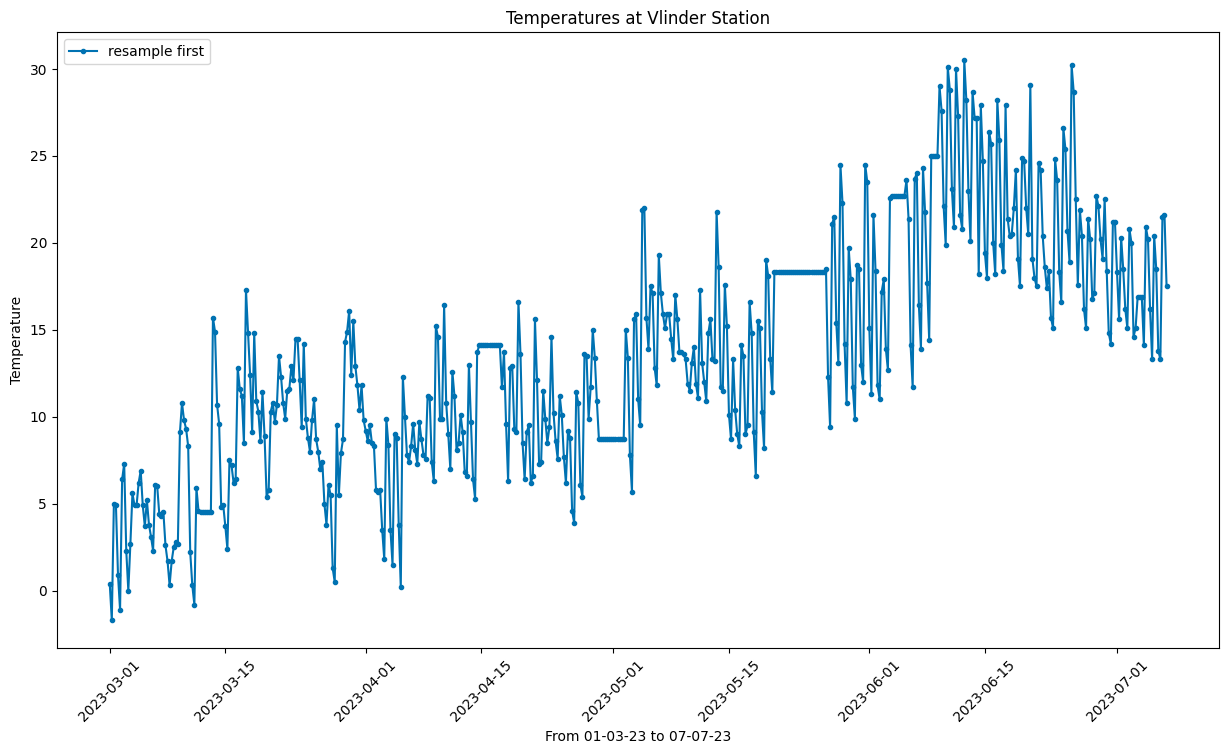

In [4]:
class Vlinder: 
    """
        Class that represents Vlinder data
        Holds original data in self.df 
        Holds resampled data in self.resample
    """
    
    def __init__(self, path_to_csv):
        self.df = pd.read_csv(path_to_csv)
        self.temp_str = self.df.columns.tolist()[0]
        self.time_str = self.df.columns.tolist()[1]
        self.df[self.time_str] = pd.to_datetime(self.df[self.time_str])
        self.resample = {"first" :  self.df.set_index(self.time_str).resample('6h').first().reset_index(),
                        "mean" : self.df.set_index(self.time_str).resample('6h').mean().reset_index()}

    def apply_dates_resize(self, first, snd):
        """
            Does a partial application of dates as we often want the same dates for different dataframes
        """
        return partial(self.resize_on_time, start=first, finish=snd)

    #TODO refactore horrible code
    def _get_time(self, df, start, finish):
        """
            Helper function to set start and finish to the min
            Start and finish can be either None, string or datetime
            Returns datetime object
        """
        if start is None: 
            start = self.earliest(df)
        elif isinstance(start, str):
            start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        else: 
            pass
        if finish is None: 
            finish = self.latest(df) 
        elif isinstance(finish, str):
            finish = datetime.datetime.strptime(finish, "%Y-%m-%d %H:%M:%S")
        else:
            pass
        return (start, finish)
        
    
    def dataframe_of_string(func):
        """
            Decorator function used to convert input dataframe string into actual dataframe
            If passed in argument is already a dataframe does nothing and passes data framethrough
            Carefull: input type is a string, new type is a dataframe
        """
        def wrapper(self, type="df", *args, **kwargs):
            if isinstance(type, str):
                type = self.select_type(type)
            return func(self, type, *args, **kwargs)
        return wrapper

    #Does not work well when chaining decorators together => Unused atm
    def handle_time(func):
        """
            Decorator used to handle start and finish times
        """
        def wrapper(self, *args, **kwargs):
            if start is None:
                start = self.earliest()
            if finish is None:
                finish = self.latest()
            return func(self, df, start, finish, *args, **kwargs)
        return wrapper

    
    def select_type(self, type="df"):
        """
            Returns dataframe corresponding to type
            types available: 
            - df : original dataframe
            - mean : dataframe resampled on mean
            - first : dataframe resampled on first
        """
        df = None
        match type:
            case "df":
                df = self.df
            case "mean":
                df = self.resample["mean"]
            case "first":
                df = self.resample["first"]
            case _ :
                raise ValueError(f"dataframe {type} does not exist")
        return df
    
    @dataframe_of_string
    def earliest(self, type="df"):
        """
            Returns earliest date in dataframe
        """
        return min(type[self.time_str])

    @dataframe_of_string
    def latest(self, type="df"):
        """
            Returns latest date in dataframe
        """
        return max(type[self.time_str])

    def plot(self, start=None, finish=None):
        """
            Plots original data points as well as resampeled on mean and first
        """
        start , finish = self._get_time(self.df, start, finish)

        # partial application of dates
        select_df = self.apply_dates_resize(start, finish)

        mean = select_df("mean")
        first = select_df("first")
        base = select_df("df")
        
        plt.figure(figsize=(15, 8))
        plt.plot(first[self.time_str], first[self.temp_str], label='resampled first', marker='o', markersize=2, linewidth=1)
        plt.plot(mean[self.time_str], mean[self.temp_str], label='resampled mean',  marker='s', markersize=2, linewidth=1)
        #plt.plot(base[self.time_str], base[self.temp_str], label='original', linestyle='--', linewidth=0.7)
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()
    
    @dataframe_of_string
    def plot_one(self, type="df", start=None, finish=None, info="df"):
        """
            Plots one of the dataframes, either df, mean or first
        """
        start , finish = self._get_time(type, start, finish)
        df_resize = self.resize_on_time(type, start, finish)
        plt.figure(figsize=(15, 8))
        plt.plot(df_resize[self.time_str], df_resize[self.temp_str], marker='o',  markersize=3, label=info) #cannot use type as label as it has been changed to dataframe through decorator
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()

    @dataframe_of_string
    def resize_on_time(self, type="df", start=None, finish=None):
        """
            Returns new data frame with values between start and finish
            type specifies on which dataframe to apply resizing (df for original, mean for resample mean and first for resample first)
            Format (%Y-%M-%D %h:%m:%s)
            
            On why start and finish = None: https://stackoverflow.com/questions/1802971/nameerror-name-self-is-not-defined
        """
        start , finish = self._get_time(type, start, finish)
        assert start >= self.earliest(type), f"{start} does not exist in dataframe"
        assert finish <= self.latest(type), f"{finish} dies not exist in dataframe"
        return type[(type[self.time_str] >= start) & (type[self.time_str] <= finish)]  

    @dataframe_of_string
    def drop_between(self, type="df", start=None, finish=None):
        """
        Drops values between [start, finish].
        If string is passed, returns new dataframe with dropped values.
        If dataframe is passed, exculdes values from that dataframe
        """
        start , finish = self._get_time(type, start, finish)
        before = type[type[self.time_str] < start]
        after = type[type[self.time_str] > finish]
        return pd.concat([before, after])

    @dataframe_of_string
    def get_cst_intervals(self, type="df"):
        """
            Returns start, end and timedelta of all constant intervals in passed dataframe
            TODO: issue is that at the moment even if two measurements are the same by chance its going to drop them anyway
        """
        #from https://stackoverflow.com/questions/66684957/is-there-a-faster-way-for-finding-the-range-of-constant-values-in-a-dataframe
        #Compares current element with prev, if (not equal) => True (1), else False (0). cumulative sum then adds.
        #If different sum goes up, else stays constant
        df = type
        groupr = df.temp.ne(df.temp.shift()).cumsum()
        #creates group of (nb, timestamp)
        mapper = list(zip(groupr, df.datetime))
        #from https://stackoverflow.com/questions/71945206/keep-duplciate-items-in-list-of-tuples-if-only-the-first-index-matches-between-t
        dct = defaultdict(list)
        for tup in mapper:
            first, _ = tup
            dct[first].append(tup)
            onlydups = [lst for firstelem, lst in dct.items() if len(lst) > 1]
        #only dups is a list of list with duplicate items
        min_max_lst = []
        for dup in onlydups:
            start = dup[0][1]
            end = dup[-1][1]
            min_max_lst.append((start, end, end - start))
        return min_max_lst

    @dataframe_of_string
    def drop_cst(self, type="df", max_delta=6):
        """
            Keeps all constant time intervals that are stricly bigger than max_delta
            Computes const values through get_cst_intervals
        """
        df = type
        min_max_lst = self.get_cst_intervals(df)
        for timestamps in min_max_lst:
            fst = str(timestamps[0])
            snd = str(timestamps[1])
            delta = (pd.to_datetime(snd) - pd.to_datetime(fst)) / np.timedelta64(1, 'h')
            if (delta > max_delta):
                df = vlinder_data.drop_between(df, start=fst, finish=snd)
        return df

vlinder_data = Vlinder('vlinder19_2023.csv')

#Plot vlinder data on time frame of forecast date avaiable
vlinder_data.plot_one(type="first", start=forecast_min, finish=forecast_max, info="resample first")

We can see from our resampled data that there are multiple periods where temperature seems to be constant. This probably indicates a measument error. We will exclude all those inadequat values from our data. 
We compute all constant time intervals through the function `get_cst_intervals()`. It is usefull to see what are the most common intervals where const values appear.

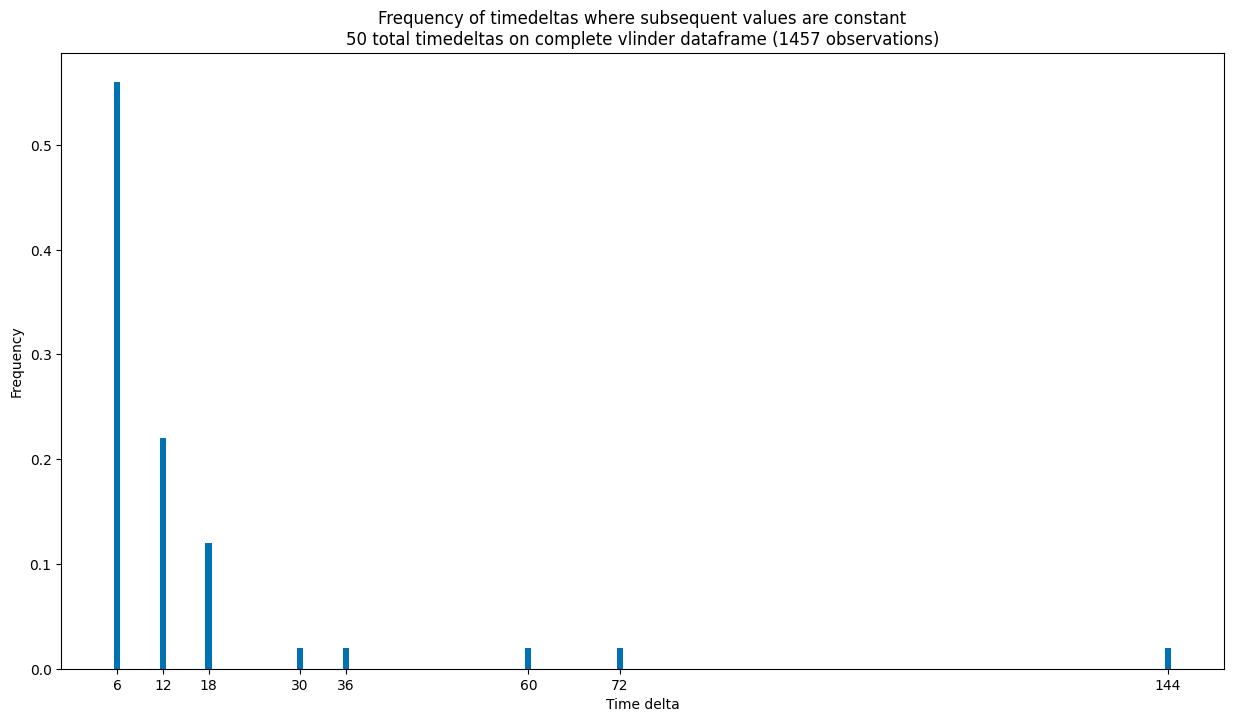

In [5]:
cst_intervals_first = vlinder_data.get_cst_intervals("first")
total_obs = len(vlinder_data.select_type("first"))
# makes list of time deltas
time_delta = list(map(lambda x : x[2], cst_intervals_first))
time_delta_to_hours = (list(map(lambda x : x.total_seconds() / 3600, time_delta)))
total_cst_elements = len(time_delta)
time, occ = np.unique(time_delta_to_hours, return_counts=True)
occ = list(map(lambda x : x / len(time_delta), occ))
plt.figure(figsize=(15, 8))
plt.bar(time, occ)
plt.xlabel('Time delta')
plt.ylabel('Frequency')
plt.xticks(time)
plt.title(f'Frequency of timedeltas where subsequent values are constant\n{total_cst_elements} total timedeltas on complete vlinder dataframe ({total_obs} observations)')
plt.show()

In [6]:
print(occ[0] + occ[1]) 

0.78


Intervals of 6 and 12 hours where consecutive values are constant represent 78% of our total time deltas. It is probable that by random chance two intervals within 12 hours are similar. (6 hours means 2 consecutive values, 12 hours means 3 consecutive values).

`drop_cst(max_delta)` is a function that drops all time intervals bigger than its given argument

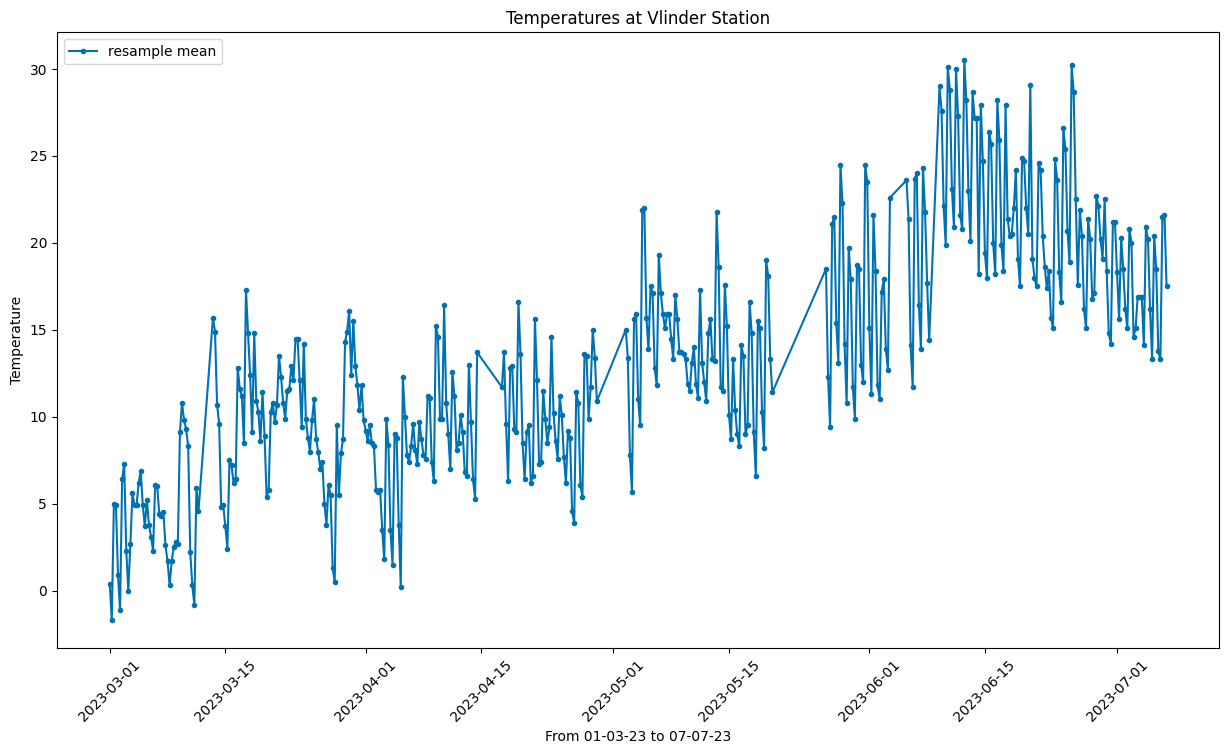

In [7]:
df = vlinder_data.resize_on_time("first", start=forecast_min, finish=forecast_max)
df = vlinder_data.drop_cst(df, 12)
vlinder_data.plot_one(df, info="resample mean")

We will arbitrarely dropping every interval where const value appear for more than 6 hours. 
But correlation between target data and measured vlinder data increases if we do 0 hours. -> should we drop all consecutive const variables?

In [8]:
drop_const_p = partial(vlinder_data.drop_cst, max_delta=0)

## Integrating Forecast and Vlinder Temperaturs
1. We need to know how to resample our Vlinder Data.
   - Compute the mean of 't2m' (which will be our explanatory variable) and correlated it to the ressampled vlinder data. We then choose the highest correlated resampling method
2. We can then merge ensemble forecasts with observed vlinder data

### 1. Selection of resampling technique

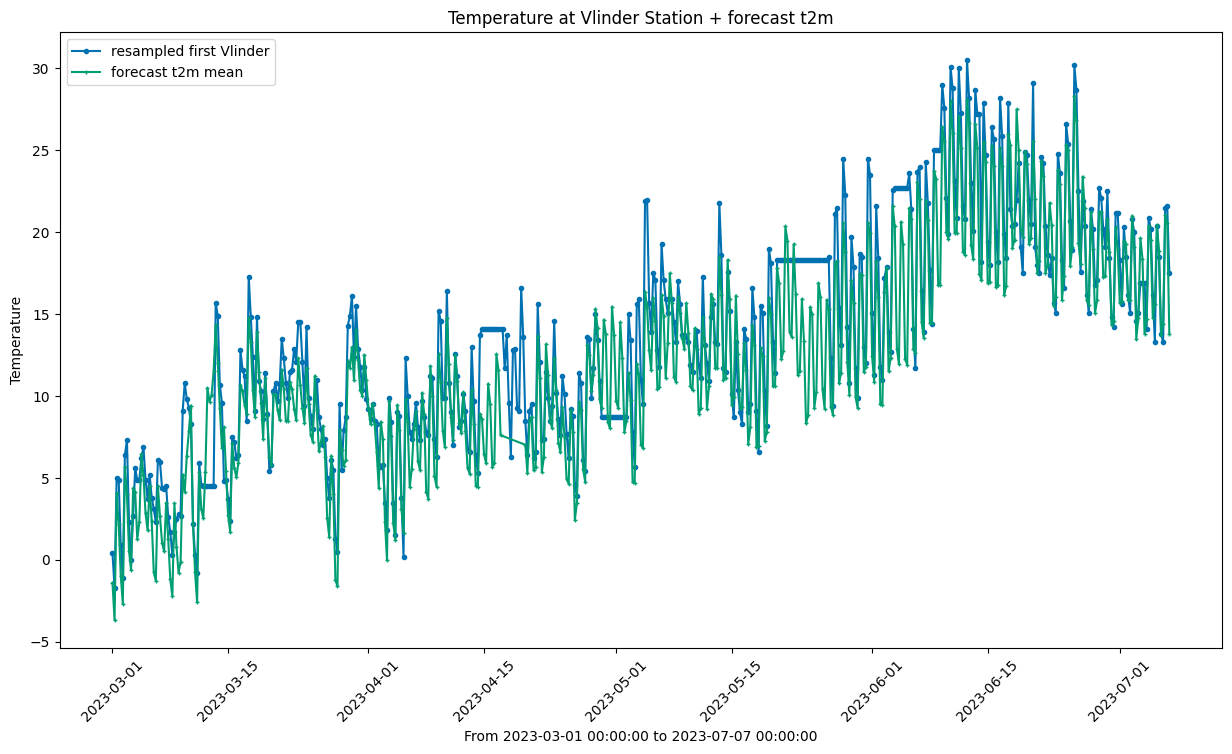

In [9]:
target = 't2m'

ensmean_forecast = forecast_data.get_df().groupby('time')[target].mean().reset_index()
ensmean_forecast[target] = ensmean_forecast[target] - Const_Conversion[target]
ensmean_forecast['time'] = pd.to_datetime(ensmean_forecast['time'])
ensmean_min, ensmean_max = forecast_data.get_min_max()

resample_select = vlinder_data.apply_dates_resize(ensmean_min, ensmean_max)
vlinder_fst = resample_select("first")
vlinder_mean = resample_select("mean")
plt.figure(figsize=(15, 8))
plt.plot(vlinder_fst[vlinder_data.time_str], vlinder_fst[vlinder_data.temp_str], marker='o', markersize=3, label='resampled first Vlinder')
#plt.plot(vlinder_mean[vlinder_data.time_str], vlinder_mean[vlinder_data.temp_str], marker='s', markersize=3,label='resampled mean Vlinder')
plt.plot(ensmean_forecast['time'], ensmean_forecast[target], marker='+', markersize=3, label=f'forecast {target} mean')
plt.legend(loc='upper left')
plt.xlabel(f"""From {ensmean_min} to {ensmean_max}""")
plt.ylabel('Temperature')
plt.title(f'Temperature at Vlinder Station + forecast {target}')
plt.xticks(rotation=45)
plt.show()

TODO: maybe change representation of this graph -> rly ugly

We need to decide whether the mean or the first value is the right choice when resampling our Vlinder Data.
We compute correlation between the mean temperature (t2m) in the forecasts and the temperature at the vlinder station.

In [10]:
#We drop the end of the vlinder data as data is wrong
resize_vlinder = vlinder_data.apply_dates_resize(forecast_min, forecast_max)

dropped_vlinder_mean = drop_const_p(resize_vlinder("mean"))
dropped_vlinder_first = drop_const_p(resize_vlinder("first"))

merge_p = partial(pd.merge, left_on=forecast_data.time_str, right_on=vlinder_data.time_str)
merged_df = merge_p(ensmean_forecast, dropped_vlinder_mean).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'mean'})
merged_df = merge_p(merged_df, dropped_vlinder_first).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'first'})

correlation_mean = merged_df['t2m'].corr(merged_df['mean'])
correlation_first = merged_df['t2m'].corr(merged_df['first'])

print(correlation_mean, correlation_first)

0.93915759318537 0.9729779000076412


We can see that resampling on first value found in the interval has a higher correlation with our main target value 't2m'. We will use this resampling technique from now on.

### 2 Merging ensemble forecasts and vlinder temperatures

We will keep all ensemble forecasts inside a list and not merge them directly inside a unique dataframe. This helps with visualization of data as well as making it easier to target individual ensemble forecasts. It also makes it more flexible to select certain dataframes in case we dont want them for some reason. This will come up handy later. We can easily do operations on those dataframes using list processing techniques such as map, reduce and partial application.

In [11]:
def create_ens_fc_list():
    """
        Creates a list of tuples containing (start_date : string, ensemble forecast: dataframe). 
        All ensemble forecast dataframes are augmented with the respective vlinder data.
        This means that some dataframes may contain less predictions as the corresponding vlinder measurement was unusable
    """
    # get list of starting dates of ensemble forecasts
    starting_dates = forecast_data.get_start_dates()

    # get corresponding vlinder data with constant values dropped as decided by drop_const_p
    vlinder_temp =  drop_const_p(resize_vlinder("first"))

    dfs = []
    for date in starting_dates:
        df = forecast_data.get_ensemble_forecast(date).reset_index()
        df[forecast_data.time_str] = pd.to_datetime(df[forecast_data.time_str])
        df = pd.merge(df, vlinder_temp, left_on=forecast_data.time_str, right_on=vlinder_data.time_str)
        df.drop(columns=vlinder_data.time_str, inplace=True)
        dfs.append((date, df))
    return dfs


#Some utility functions use to handle list of tuples generated by previous function
def nb_observation(df):
    return len(df.index) // 50

def date_and_obs(tp):
    start, df = tp
    return (str(start), nb_observation(df))

def only_date(tp):
    date, _ = tp 
    return date

def only_df(tp):
    _, df = tp
    return df

def merge_df(df_1, df_2):
    """
        Merges two dataframes
    """
    combined_df = pd.concat([df_1, df_2], ignore_index=False)
    return combined_df

def reduce_df(dfs_list):
    """
        Reduces all dataframes from the input list into one
    """
    reduced_df = reduce(merge_df, map(only_df, dfs_list))
    return reduced_df

dfs = create_ens_fc_list();
#contains number of observation left for each time forecast
samples_per_fc = list(map(date_and_obs, dfs))
samples_per_fc

[('2023-03-01 00:00:00', 27),
 ('2023-03-02 00:00:00', 27),
 ('2023-03-03 00:00:00', 27),
 ('2023-03-10 00:00:00', 23),
 ('2023-03-15 00:00:00', 29),
 ('2023-03-19 00:00:00', 27),
 ('2023-03-25 00:00:00', 29),
 ('2023-03-30 00:00:00', 29),
 ('2023-04-05 00:00:00', 27),
 ('2023-04-10 00:00:00', 17),
 ('2023-04-20 00:00:00', 29),
 ('2023-04-25 00:00:00', 17),
 ('2023-04-30 00:00:00', 19),
 ('2023-05-05 00:00:00', 25),
 ('2023-05-10 00:00:00', 29),
 ('2023-05-15 00:00:00', 22),
 ('2023-05-20 00:00:00', 4),
 ('2023-05-25 00:00:00', 22),
 ('2023-05-30 00:00:00', 22),
 ('2023-06-05 00:00:00', 23),
 ('2023-06-10 00:00:00', 27),
 ('2023-06-15 00:00:00', 29),
 ('2023-06-20 00:00:00', 29),
 ('2023-06-25 00:00:00', 27),
 ('2023-06-30 00:00:00', 24)]

Except for the forecast starting on `2023-05-20 00:00:00`, most of the forecast still have information left in them. We will remove this forecast as it does not give enough information to accurately depcit an ensemble forecast

In [12]:
#timestamp object of forecast that the least amount of info (here 4)
not_enough_info = pd.to_datetime(min(samples_per_fc, key=lambda x: x[1])[0])
not_enough_info

Timestamp('2023-05-20 00:00:00')

In [13]:
number_of_obs = reduce(lambda x, y: x + y, map(lambda tp : tp[1], samples_per_fc))
number_of_obs

610

We have 635 different forecast values (depends on drop_const function)

# Splitting Train, Validation and Test sets

As we want to train multiple models to see which has the best outcomes we want to split our data. We will do so by keeping ensemble forecasts together by starting date. Some ensemble forecast will be used to train the models, other to validate and a final ensemble forecast will be used to do the final assessment. 

However we might face data leakage if we do random splitting as we have overlapping forecasts. This means that the same target variable ('t2m') might end up in a training sample and in a test sample. We need to do further analysis to verify how our data behaves and what suitable splitting techniques are. We could either: 
- Drop all overlapping data so that each value is unique.
- Combine overlapping data in a mean value
- If variation in forecast and measurement are not dependend on time we could split on time periods, keeping forecasts together on time

Selected solution: as no pattern seems to appear with time we split the data time based and remove overlapping values. 

## Analysis of relation between target temperature and ensemble forecasts

We will first analyse the difference between the measured temperature at the vlinder station and the t2m variable (=relative error) to see if there are any difference thourghout the year. Does the forecast overshoot or undershoot the measured data depending on season of the year?

### 1. Analysis of relative error between forecast and measured temperature

In [14]:
df_diff = create_ens_fc_list()

def keep_columns(to_keep, df):    
    return df[to_keep]

def group_time(df):
    mean_fc = df.groupby('time').mean()
    mean_fc['t2m'] = mean_fc['t2m'] - C_0
    return mean_fc

def diff_tm2_tmp(df):
    df['diff'] = df['t2m'] - df['temp']
    return df

def create_mean(df):
    """
        Creates column holding mean of difference 
        Requires that diff column has already been computed
    """
    df['mean_diff'] = df['diff'].mean()
    return df

keep_cols = partial(keep_columns, ['time', 't2m', 'temp'])

operations = compose(create_mean, diff_tm2_tmp, group_time, keep_cols, only_df)

list_df_diff = list(map(operations, df_diff))

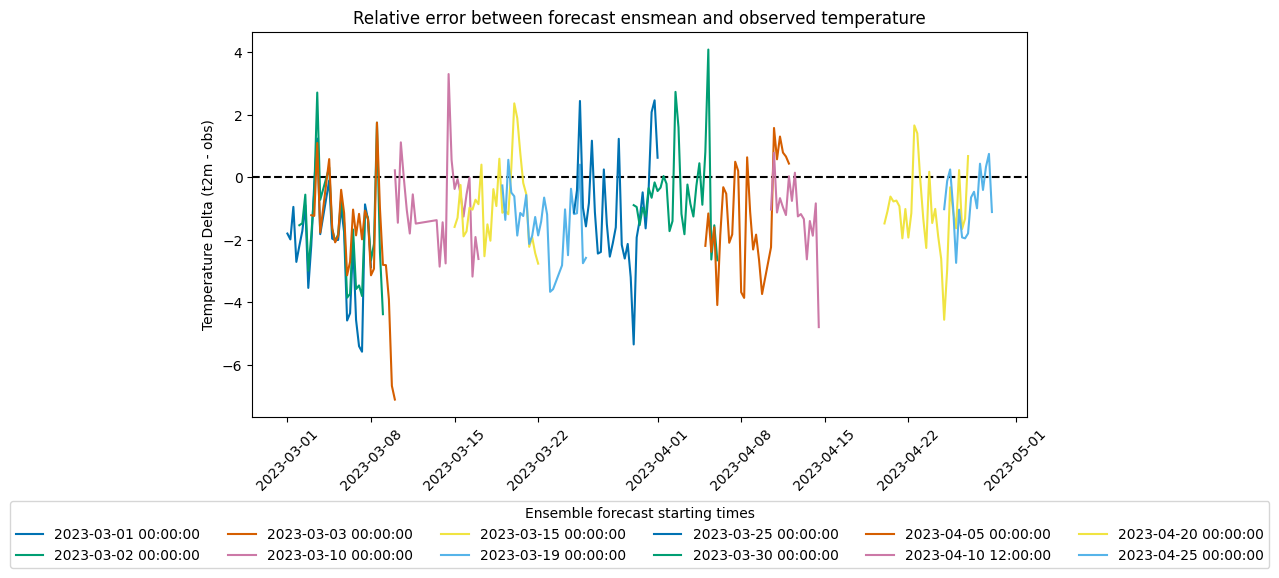

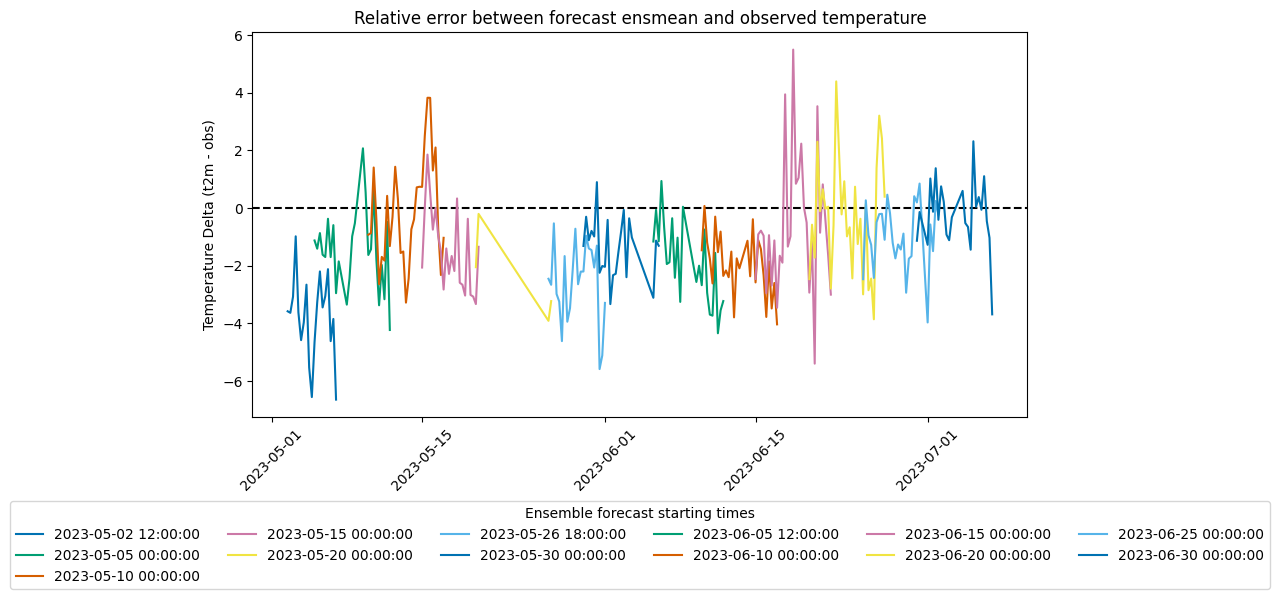

In [15]:
def plot_lst(df_lst, on='diff', ylabel='Temperature Delta (t2m - obs)', title="Relative error between forecast ensmean and observed temperature"):
    """
        Plots all dataframes in list given as argument on parameter passed as argument
    """
    plt.figure(figsize=(10, 5))
    plt.axhline(0, color='black', linestyle='--')
    for df in df_lst:
        start = df.index[0]
        df = df.reset_index()
        plt.plot(df[forecast_data.time_str], df[on], label=start)
    plt.legend(title="Ensemble forecast starting times", loc='upper center', bbox_to_anchor=(0.5, -0.2), ncols=6)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_lst(list_df_diff[: len(list_df_diff) // 2])
plot_lst(list_df_diff[len(list_df_diff) // 2 :])

We plot the difference between forecast data and observed data. If we are above 0 degrees this means that our forecast predicted a warmer temperature than the measured one. We can see here that our forecasts tend to predict lower temperatures than those who where effectively measured (as most of the graph is under the even line diff temp = 0).

However it is hard to see if this `Temperature Delta` changes on a seasonal basis (natural environment of vlinder station might have different influences if its winter or summer).


We will thus compute the mean and the variance for the relative error each ensemble forecast to see how it changes on a seasonal basis

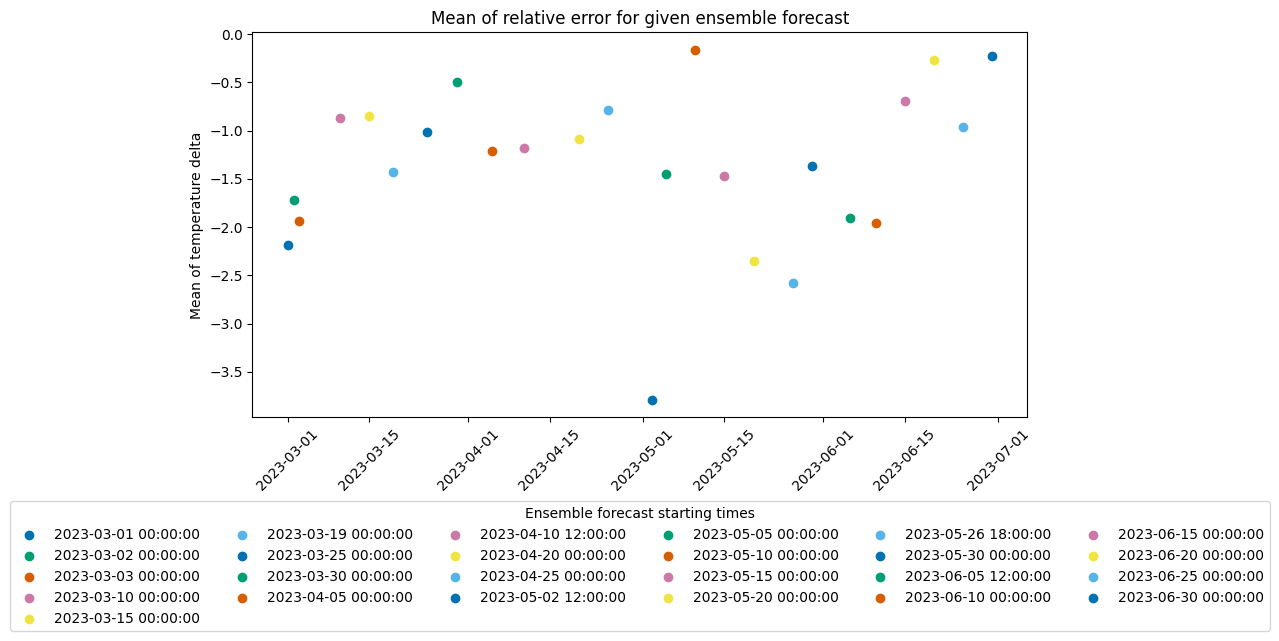

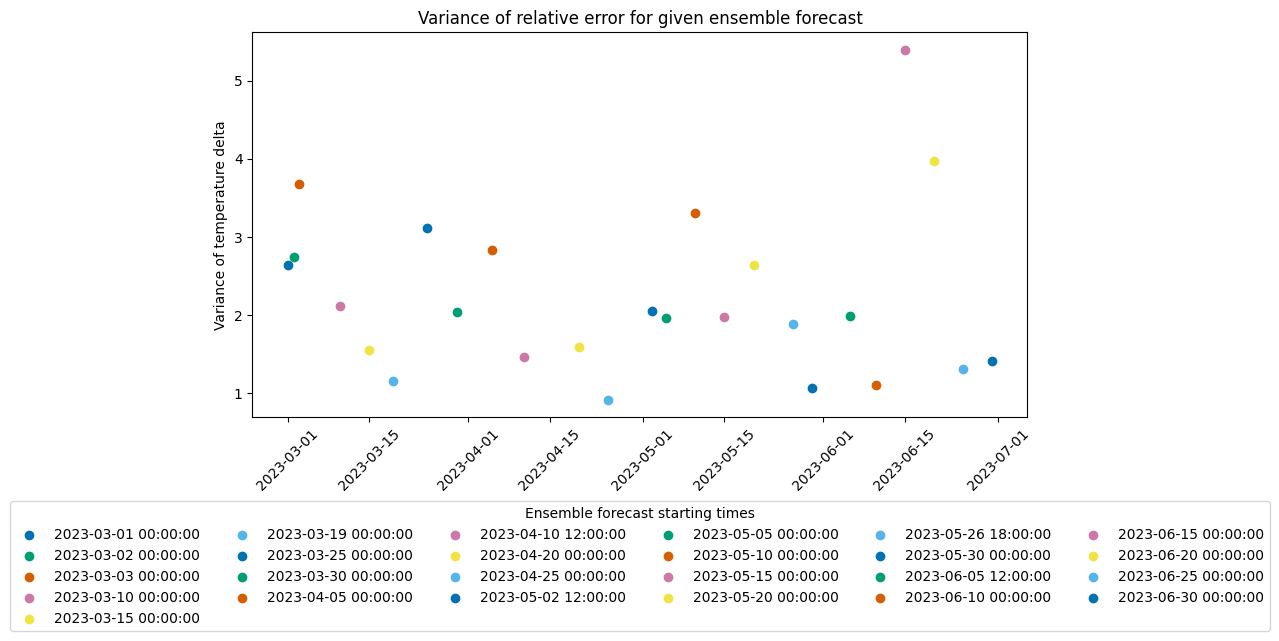

In [16]:
def compute_variance(target, df):
    """
        Computes variance on columns for given dataframe
    """
    df[f'{target} var'] = df[target].var()
    return df

def scatter_list_var(df_lst, on='diff var', ylabel='missing label', title="missing title"):
    """
        Plots all dataframes in list given as argument on parameter passed as argument
    """
    # y = list(map(lambda df: df[on].to_list()[0], df_lst))
    # x = list(map(lambda df: df.reset_index()['time'].to_list()[0], df_lst))
    # x = x 
    # x = [timestamp.astype(np.int64) // 10**9 for timestamp in x]
    # print(x)
    #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    plt.figure(figsize=(10, 5))
    for df in df_lst:
        start = df.index[0]
        df = df.reset_index()
        plt.scatter(df[forecast_data.time_str], df[on].values, label=start)
    plt.legend(title="Ensemble forecast starting times", loc='upper center', bbox_to_anchor=(0.5, -0.20), ncols=6)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

scatter_list_var(list(map(lambda df : df.iloc[[0]], list_df_diff)), on='mean_diff', ylabel='Mean of temperature delta', title='Mean of relative error for given ensemble forecast')

compute_variance_diff = partial(compute_variance, 'diff')

list_df_var = list(map(compute_variance_diff, list_df_diff))
#selects only first occurence for each ensemble forecast
diff_var_first = list(map(lambda df : df.iloc[[0]], list_df_var))
scatter_list_var(diff_var_first, on='diff var', ylabel='Variance of temperature delta',  title='Variance of relative error for given ensemble forecast')


Mean and variance are looking quite constant and not dependend on season. 
There are however a few outliers, one sample seems to be especially cold and another seems to have high variance. We will plot those values onto histograms to make it appear more clearly. 

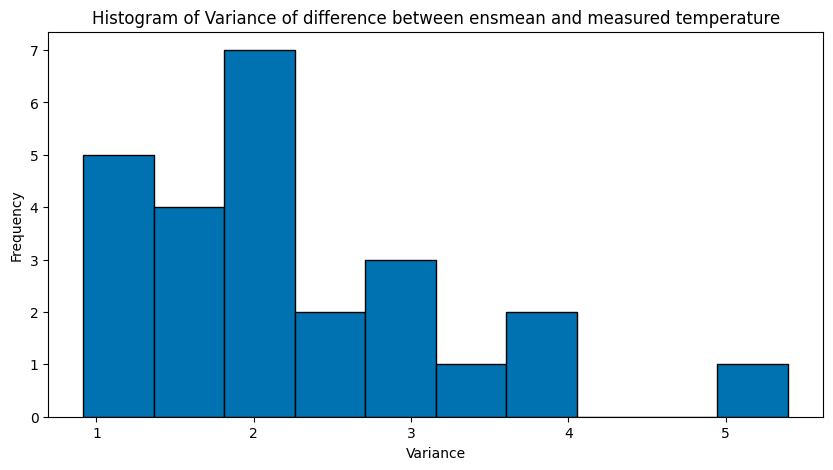

In [17]:
diff_var_first_merged = reduce(merge_df, diff_var_first)

plt.figure(figsize=(10, 5))
plt.hist(diff_var_first_merged['diff var'], bins=10, edgecolor='black') # Adjust bins as needed
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Variance of difference between ensmean and measured temperature')
plt.show()

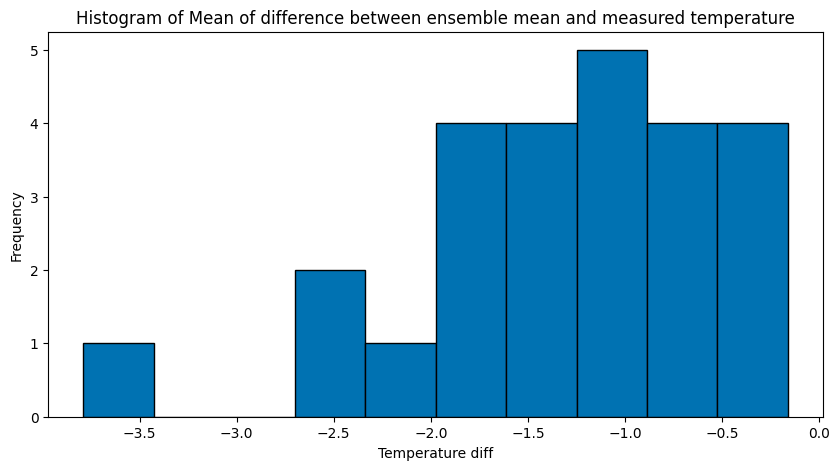

In [18]:
diff_mean = reduce(merge_df, list(map(lambda df : df.iloc[[0]], list_df_var)))

plt.figure(figsize=(10, 5))
plt.hist(diff_mean['mean_diff'], bins=10, edgecolor='black')
plt.xlabel('Temperature diff')
plt.ylabel('Frequency')
plt.title('Histogram of Mean of difference between ensemble mean and measured temperature')
plt.show()

We can see that our forecast with variance 5 aswell as our forecast with mean temperature -3.5 are definitively outliers and should be dropped. However what to conclude for other values ? 
We should try to predict distribution and then do some hypothesis testing to remove outliers more mathematically.

In [19]:
outliers = [diff_var_first_merged['diff var'].idxmax(), diff_mean['mean_diff'].idxmax()]
outliers

[Timestamp('2023-06-15 00:00:00'), Timestamp('2023-05-10 00:00:00')]

In [20]:
# #from https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3
# import scipy.stats as st
# def get_best_distribution(data):
#     dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
#     dist_results = []
#     params = {}
#     for dist_name in dist_names:
#         dist = getattr(st, dist_name)
#         param = dist.fit(data)

#         params[dist_name] = param
#         # Applying the Kolmogorov-Smirnov test
#         D, p = st.kstest(data, dist_name, args=param)
#         print("p value for "+dist_name+" = "+str(p))
#         dist_results.append((dist_name, p))

#     # select the best fitted distribution
#     best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
#     # store the name of the best fit and its p value

#     print("Best fitting distribution: "+str(best_dist))
#     print("Best p value: "+ str(best_p))
#     print("Parameters for the best fit: "+ str(params[best_dist]))

#     return best_dist, best_p, params[best_dist]

# params = get_best_distribution(tmp_merged['diff var'].values)

In [21]:
dfs = create_ens_fc_list()

to_remove = outliers + [not_enough_info]

"""
    In the ensemble forecast list (dfs), tp[0] are timestamp objects, not strings => to_remove list should contain
    timestamp objects
"""
cleared = list(filter(lambda tp : tp[0] not in to_remove, dfs))

assert len(cleared) + len(to_remove) == len(dfs)

def select_chronologically(dfs_list, train_p=0.6, val_p=0.2):
    """
        Selects in order of appearance: first 'train_p'% values are going into train set, following `val_p`% are going into train set 
        and rest goes into test set
        Might not be exatly split as some dataframe contain different number of observations after data cleaning
        We have a lot of overlapping data in the beggining (from 1-03 to 3-03), is this an issue?
    """
    nb_elem = len(dfs_list)
    train_index_max = int(nb_elem * train_p)
    
    train_set = dfs_list[: train_index_max]
    
    val_index_max = int(nb_elem * (train_p + val_p))
    val_set = dfs_list[train_index_max: val_index_max]
    
    test_set = dfs_list[val_index_max:]

    contains_common_elements = set(map(only_date, train_set)) & set(map(only_date, val_set)) & set(map(only_date, test_set))
    assert not contains_common_elements, "train, validation and test contain same ensemble forecast"

    return (train_set,val_set,test_set)

def select_randomly(dfs_list, train_p=0.6, val_p=0.2):
    """
        Splits randomly values from from given input dataframe list into (train_set, val_set, test_set)
        TODO: might not be exatly as dataframe contain different number of observations after data cleaning
    """
    nb_elem = len(dfs_list)
    
    nb_train_elements = int(nb_elem * train_p)
    train_set = sorted(random.sample(dfs_list, nb_train_elements), key=lambda x : x[0])

    #list of not selected elements
    rest = sorted([tp for tp in dfs if tp not in train_set], key=lambda x : x[0])

    nb_val_elements = round(nb_elem * val_p)
    
    validation_set = sorted(random.sample(rest, nb_val_elements), key=lambda x : x[0])

    test_set = sorted([tp for tp in rest if tp not in validation_set], key=lambda x : x[0])

    contains_common_elements = set(map(only_date, train_set)) & set(map(only_date, validation_set)) & set(map(only_date, test_set))
    assert not contains_common_elements, "train, validation and test contain same ensemble forecast"
    return (train_set, validation_set, test_set)

def get_unique_timestamps_set(df_list):
    """
        returns set of all timestamps of the list of dataframe passed as argument
    """
    operations = compose(lambda np_arr: np_arr.tolist(), lambda df: df['time'].unique(), only_df)
    return set(reduce(operator.concat, list(map(operations, df_list))))

def select_unique(dfs_list, train_p=0.6, val_p=0.2): 
    """
        We need to make sure that no common dates are appearing in train, validation and test set
        1. extract all unique time stamps from train, validation and test set
        2. As we select chornologically we need to check only if there is overlapping data between train-val and val-test
        3. Remove overlapping data from the earliest dataframe, (=> from train in train-val and from val in val-test). 
            -> This favors that is a bit more recent in the 
    """
    train, val, test = select_chronologically(dfs_list, train_p, val_p)
    operations = compose(lambda np_arr: np_arr.tolist(), lambda df: df['time'].unique(), only_df)
    
    #list containing sublists with all unique time stamps within a given dataframe
    unique_dates_train = get_unique_timestamps_set(train)
    uniques_dates_val = get_unique_timestamps_set(val)
    uniques_dates_test = get_unique_timestamps_set(test)

    conflict_train_val = unique_dates_train & uniques_dates_val
    conflict_val_test = uniques_dates_val & uniques_dates_test
    
    # Removes conflicting values from train and validation sets
    train = list(map(lambda tp: (tp[0], tp[1][~tp[1]['time'].isin(list(conflict_train_val))]), train))
    val = list(map(lambda tp: (tp[0], tp[1][~tp[1]['time'].isin(list(conflict_val_test))]), val))
    
    return (train, val, test)

train_set, val_set, test_set = select_unique(cleared)

unique_dates_train = get_unique_timestamps_set(train_set)
unique_dates_val = get_unique_timestamps_set(val_set)
unique_dates_test = get_unique_timestamps_set(test_set)

assert len(cleared) == len(train_set) + len(val_set) + len(test_set), f"Inital list and sum of generated list do not have the same number of elements {len(cleared)} != {len(train_set)} + {len(val_set)} + {len(test_set)}"
assert len(unique_dates_train & unique_dates_val) == 0, f"Train and validation sets contain same dates {unique_dates_train & unique_dates_val}"
assert len(unique_dates_val & unique_dates_test) == 0, f"Val and Test sets contain same dates {unique_dates_val & unique_dates_test}"
assert len(unique_dates_train & unique_dates_test) == 0, f"Train and Test sets contain same dates {unique_dates_train & unique_dates_test}"


TODO: 
- What about cross validation? 
- What about test set contamination -> Same Target Temperature value is contained in overlapping dataframes (e.g. `2023-03-01 00:00:00'` and `2023-03-02 00:00:00` both contain the same values from 2nd day on)
    - We could split here by making sure that time period dont overlap. This could work if there is not more variance depending on the season (are our measured temperatures relatively hotter in the summer?)
 
At the moment we juste take the 60% fst percent for testing, the 20 subsquent for validation and last 20 for testing

### Dependencies Analysis

As our data is now merged, we will analyze dependencies between our feature variables (from the ensemble forecast) and our target variables (observed vlinder temperature)

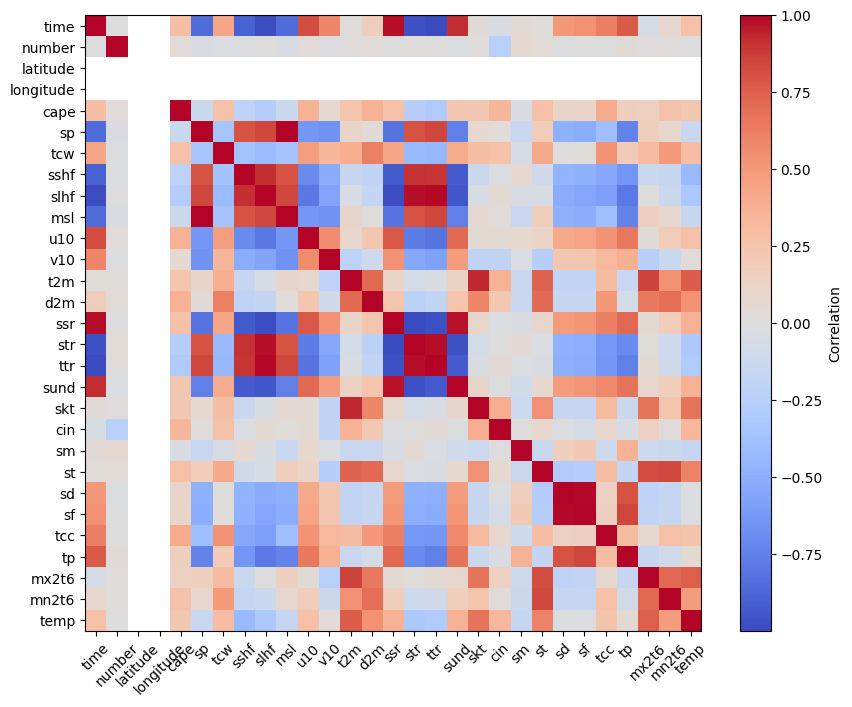

In [22]:
def display_corr_matrix(df):
    corr_matrix = df.corr() 
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest') 
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.colorbar(label='Correlation')
    plt.show()
df_1 = train_set[0][1]

display_corr_matrix(df_1)

In [23]:
complete_df = reduce_df(train_set)

correlations = complete_df.corr()['temp'].sort_values(ascending=False).drop('temp')
correlations

t2m          8.803492e-01
mx2t6        8.451093e-01
skt          8.288988e-01
st           8.021730e-01
mn2t6        7.393312e-01
d2m          7.190329e-01
tcw          6.104325e-01
time         4.820501e-01
v10          3.770467e-01
sm           3.155401e-01
ssr          2.663324e-01
sund         2.431575e-01
tcc          2.135004e-01
u10          1.993799e-01
cape         1.321426e-01
tp           1.148917e-01
number      -3.079451e-15
sshf        -4.175351e-02
ttr         -4.937612e-02
str         -9.193871e-02
cin         -1.266787e-01
sf          -1.840566e-01
sp          -1.947896e-01
msl         -2.059367e-01
sd          -2.324690e-01
slhf        -3.271183e-01
latitude              NaN
longitude             NaN
Name: temp, dtype: float64

Without surprise we can see from the correlation matrix that the features from the ensemble forecast that are highly correlated with the vlinder temperature are those measuring some kind of temperature (t2m, d2m, mx2t6, mn2t6,..). However those variables are also heavily cross-correlated, which means that we might want to drop them later.

Latitude and longitude are constant values that hold no explicative power, we will drop them later

We also need to check for NaN values.


In [24]:
#Display columns that have NaN values and percentage of NaN values
def nan_info(df):
    for column in which_col_nan(df):
        nan_percent = get_nan_percent(df[column], df.shape[0])
        print(f"{column} has {nan_percent * 100:.2f} % of NaN values" )
        
#Returns list of Columns that have nan values
def which_col_nan(df):
    return df.columns[df.isna().any()].tolist()

def get_nan_percent(df_col, df_entries):
    return df_col.isna().sum() / df_entries

nan_info(complete_df)

cin has 85.44 % of NaN values
mx2t6 has 3.46 % of NaN values
mn2t6 has 3.46 % of NaN values


We can see that cin has a large amount of NaN values and mx2t6 and mn2t6 have smaller amount, we will definitevely drop cin, but we could extrapolate mx2t6 it appears to be interesting

In [25]:
# Returns list of columns who have a number of unique features = 1 (=> all the same values)
# from https://studymachinelearning.com/pandas-how-to-remove-dataframe-columns-with-constant-same-values/
def constant_value_features_columns(df):
    return [e for e in df.columns if df[e].nunique() == 1]

def remove_cst_values(df):
    to_keep = [e for e in df.columns if e not in constant_value_features_columns(df)]
    return df[to_keep]

def remove_nan_values(df):
    na_cols = which_col_nan(df)
    return df.drop(columns=na_cols, axis=1)

def clean_dfs(df_lst):
    """ 
        Takes in a LIST of [(timestamp, dataframes)]
        Applies above mentionned transformations to a list of dataframes
            - Removes columns with all const values
            - Removes columns with NaN values
        Returns only one dataframe 
    """
    reduce_merge_train = reduce(merge_df, map(only_df, df_lst))
    return clean_one(reduce_merge_train)

def clean_one(df):
    """
        Takes in a dataframe, applies transformations
        - Removes columns with all const values
        - Removes columns with NaN values
        Returns cleaned dataframe
    """
    transform_operations = compose(remove_cst_values, remove_nan_values)
    cleaned_df = transform_operations(df)
    return cleaned_df


tmp = clean_dfs(train_set)
tmp

,time,number,cape,sp,tcw,sshf,slhf,msl,u10,v10,...,ttr,sund,skt,sm,st,sd,sf,tcc,tp,temp
0,2023-03-01 00:00:00,1,0.000000,102126.210,6.714889,-117.5,-127.0,103096.090,-0.985653,-1.660708,...,0.0,0.00,269.20410,347.42044,275.79584,0.0,0.0,1.556484,9.536743e-07,0.4
1,2023-03-01 00:00:00,2,0.000000,102133.650,6.498146,-117.5,-127.0,103103.970,-1.522217,-2.057304,...,0.0,0.00,269.66020,338.56020,275.89400,0.0,0.0,0.000000,9.536743e-07,0.4
2,2023-03-01 00:00:00,3,0.000000,102119.945,6.799605,-117.5,-127.0,103089.580,-1.284668,-1.731162,...,0.0,0.00,269.31256,350.98910,275.68307,0.0,0.0,0.781292,9.536743e-07,0.4
3,2023-03-01 00:00:00,4,0.000000,102120.590,7.023780,-117.5,-127.0,103091.086,-1.273917,-1.996072,...,0.0,0.00,269.56317,358.10077,275.86673,0.0,0.0,0.781292,9.536743e-07,0.4
4,2023-03-01 00:00:00,5,0.000000,102109.240,6.827844,-117.5,-127.0,103079.080,-1.361147,-1.904866,...,0.0,0.00,269.51580,340.47208,275.64920,0.0,0.0,1.556484,9.536743e-07,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023-05-04 18:00:00,46,24.444702,100256.734,21.600430,-13739385.0,-34348264.0,101151.414,-1.064764,-0.607237,...,-93393270.0,185925.30,290.04510,350.54608,286.49545,0.0,0.0,53.454490,3.624342e+00,22.0
496,2023-05-04 18:00:00,47,18.383987,100067.750,27.604856,-10608839.0,-32387058.0,100964.720,-4.223812,-1.798035,...,-92782760.0,187263.00,288.73340,350.66745,286.47060,0.0,0.0,99.999420,5.109325e+00,22.0
497,2023-05-04 18:00:00,48,4.684677,100167.470,24.164522,-15571140.0,-34299510.0,101066.430,-1.718390,0.132482,...,-90587976.0,185566.75,287.81580,347.65005,285.33713,0.0,0.0,99.993320,3.713278e+00,22.0
498,2023-05-04 18:00:00,49,6.941391,100395.220,26.728205,-10012740.0,-30499442.0,101302.540,3.738906,2.557941,...,-91933730.0,158652.03,287.51706,377.38217,286.23914,0.0,0.0,99.999420,9.707068e+00,22.0


# Training Models

For each model we will:
1. Clean and transform the train data to prepare it for the model
2. Fit the model
3. Try the model on validation data.
    - We might need to transform validation data aswell
    - Compute the corrected forecast values and and take the mean. We can then compare this mean to our measured temperature on the same interval

## Linear Regression
"Least-squares regression is applied on training data to estimate a linear relationship between predictions and corresponding observations" from _Vannitsem, S., Wilks, D. S., & Messner, J. W. (Elsevier). (2018). Statistical Postprocessing of Ensemble Forecasts_

We will imply fit a linear regression where the dependent variable is the measured temperatur and the independent variables are the means of the ensemble forecast for each measurement.

### 1. Clean and transform data

In [26]:
#TODO: we need to do the same for validation set

def transform_df_lr_lst(df_list):
    """
        Applies specific transformation operations to process list of dataframes, either for training, validation or testing
    """
    df = reduce_df(df_list)
    df = df[['t2m', 'temp', 'time']]
    #We group on time and t2m is the mean of the ensemble forecast
    #If we have multiple forecasts for the same date we have the mean of all those forecats
    #We could build a model where we only keep the latests date, might improve short term prediction
    df = df.groupby('time').mean()
    #keep everything in Kelvin as it is the target
    df['temp'] = df['temp'] + C_0
    return df

def transform_df_lr_fc(df):
    """
        Creates numpy array to be fed to model.fit function from dataframe 
    """    
    return df['t2m'].values.reshape(-1, 1)

df_train = transform_df_lr_lst(train_set)

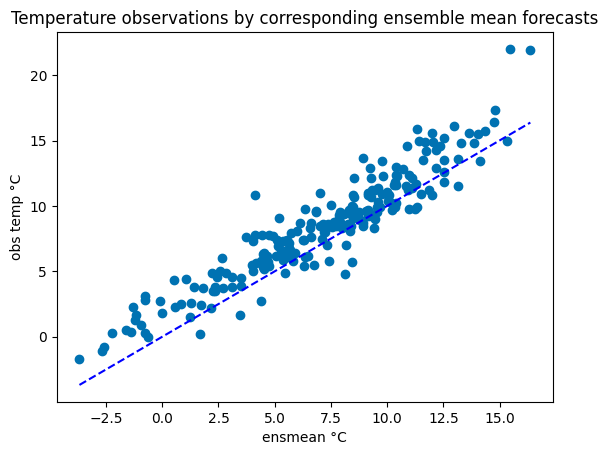

In [27]:
x = np.linspace(min(df_train['t2m'] - C_0), max(df_train['t2m'] - C_0))
y = x

plt.scatter(df_train['t2m'] - C_0, df_train['temp'] - C_0, marker='o')
plt.plot(x , y, linestyle='--', color='blue', label='x = y')
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Temperature observations by corresponding ensemble mean forecasts')
plt.show()

We can see that we have a negative bias in our ensemble forecast as most of our data points are above the x = y line

### 2. Fit the model

In [28]:
X_train = df_train['t2m'].values.reshape(-1, 1)
y_train = df_train['temp'].values.reshape(-1, 1)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from codecarbon import EmissionsTracker

#@track_emissions()
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model


linear_regression = train_model(LinearRegression(), X_train, y_train)

In [45]:
def correct_forecast(df_to_correct, model, transform_func):
    """
        Takes in dataframe to correct (non processed), model to use for correction and function that corrects the dataframe to be fed to the model
        Returns corrected ensemble t2m values for given forecast.
        Should save target
        Returns input dataframe with corrected 't2m' values
    """
    #TODO : transform_func could be a function within a class and we pass just the the class in
    x = transform_func(df_to_correct)
    
    y = model.predict(x)

    corrected = df_to_correct.copy()
    corrected['t2m'] = y

    return corrected

## Random Forest Regression

In [31]:
random_forest_train = reduce_df(train_set)
random_forest_train

y_train_rf = random_forest_train[['temp']] + C_0
X_train_rf = random_forest_train.drop(columns=['temp', 'time'])
X_train_rf = clean_one(X_train_rf)

In [52]:
from sklearn.feature_selection import SelectKBest, f_regression

#should check by also adding tcw as a value
selector = SelectKBest(k=1, score_func=f_regression)
X_selected = selector.fit_transform(X_train_rf, y_train_rf.values.ravel())
cols_idxs = selector.get_support(indices=True)
X_train_rf = X_train_rf.iloc[:,cols_idxs].reset_index().drop(columns='index')

rf_selected_features = X_train_rf.columns.to_list()

print(X_train_rf.values)

[[271.34305]
 [271.92282]
 [271.5465 ]
 ...
 [288.75406]
 [287.9074 ]
 [286.1313 ]]


What about multicolinearity when selecting K best features ? We could use PCA or drop them.

We create a baseline random forest regressor. We will use this base line regressor to compare to tuned random forest

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_regression

#fit baseline RF
rf_base = RandomForestRegressor(n_estimators= 20, random_state=42)
rf_base.fit(X_train_rf.values, y_train_rf['temp'].values.reshape(-1, 1).ravel());

In [44]:
def transform_df_rf_fc(features_list, df):
    """
        Selects all features from feature_list from dataframe and creates data in the right form
        to be processed by randomForst.predict
    """
    df = df[features_list]
    return df.values

In [35]:
# #from https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%201.ipynb
# features_list = X_train_rf.columns

# importances = list(rf_base.feature_importances_)

# feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]

# # Sort the feature importances by most important first
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# # Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [36]:

#@track_emissions
@timer
def randomSearch(x_train, y_train):
    """
        Used to get a rough estimate of what our hyper parameters should look like
        This function takes too much time, we might want to reduce train values
    """
    #from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    # nb of trees in the forest
    n_estimators = [int(x) for x in np.linspace(start = 2, stop = 400, num = 10)]
    max_features = ['log2', 'sqrt', 1.0]
    # max depth of the tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    # if depth is None: nodes are expanded or until leaves contain less than min samples split
    max_depth.append(None)
    # min number of samples to split a node
    min_samples_split = [2, 5, 10]
    # min number of samples to be a leaf node
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf, 
                   'bootstrap': bootstrap}
    
    rf_regressor = RandomForestRegressor()
    
    rf_random = RandomizedSearchCV(estimator = rf_regressor, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
    rf_random.fit(x_train, y_train.values.ravel())
    return rf_random.best_params_

#params selected here will also depend on the k best selected params earlier
#random_best_params = randomSearch(X_train_rf, y_train_rf)
#random_best_params

We got a better idea what our hyperparameters should look like, instead of doing it randomly now we will try to improve it a bit more by doing a GridSearch

In [37]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [60, 70, 80],
#     'max_features': [1, 2, 3],
#     'min_samples_leaf': [1, 2, 3, 4, 5],
#     'min_samples_split': [2,4,8],
#     'n_estimators': [100, 200, 250]
# }

# rf = RandomForestRegressor()
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train_rf, y_train_rf)
# grid_search.best_params_

# Comparing different Models

In [38]:
def get_measure(corr_val, target_val):
    """
        Returns mean squared error and determination coefficient between 
        the corrected values and the target value
    """
    corrected_mean = corr_val.mean(axis=1)
    y_val = target_val.groupby('time').mean() + C_0

    mse = mean_squared_error(y_val, corrected_mean)
    r2_s = r2_score(y_val, corrected_mean)
    return (mse, r2_s)  

def fill_nan(lst, mask):
    """
        Fills array with nan where mask == False, else keeps value from lst
    """
    i = 0
    j = 0
    result = []
    while i != len(mask):
        if mask[i] == True:
            result.append(lst[j])
            j += 1
        else: 
            result.append(np.nan) 
        i += 1
    assert len(result) == len(mask)
    return result
            
def display_original_corr(original_fc, corr_fc, measured):
    """
        Takes as input list of original forecast, list of corrected forecast and list of measured temperatures
        Outputs graph with original forecast, corrected forecast and measured temperature 
        Computing mse and r2_s for each sample and then computing mean of those scores.
    """
    assert len(corr_fc) == len(measured), "List of corrected forecast and measured forecasts dont have the same lenght"
    nb_of_samples = len(corr_fc)
    fig, ax = plt.subplots(nb_of_samples, figsize=(15, 25))
    
    mse_list = []
    r2_s_list = []
    
    for i in range(0, nb_of_samples):
        corr_df = corr_fc[i][['number', 'time', 't2m']]
        corr_df = corr_df.pivot(index='time', columns='number', values='t2m')
        
        measured_df = measured[i]
        original_df = original_fc[i]

        #all those should be simple arrays
        corrected_mean = corr_df.mean(axis=1).values
        corrected_min = corr_df.min(axis=1).values
        corrected_max = corr_df.max(axis=1).values
        
        original_mean = (original_df.groupby('time').mean()).values.flatten()
        measured_temp = (measured_df.groupby('time').mean() + C_0).values.flatten()

        #Need to get measures first before adding nan values
        mse, r2_s = get_measure(corr_df, measured_df)

        mse_list.append(mse)
        r2_s_list.append(r2_s)
        
        start = corr_df.reset_index()['time'].min()
        end = corr_df.reset_index()['time'].max()

        #All 6hours intervals between start and end
        total_time_period = (end - start) / pd.Timedelta(hours=6)
        hours =  np.arange(0, 6 * total_time_period + 1, 6)

        #all measurement periods in forecast
        time_stamp_list = corr_df.reset_index()['time'].values
        
        # difference between each time stamp in ns, converted into hours
        # #!!This will hold one less value as time_stamp_list as we compute the difference between first and second term
        diff_stamp = list(map(operator.sub, time_stamp_list[1:], time_stamp_list[:])) / np.timedelta64(1, 'h')

        #holds time stamps from corrected dataframe
        cumul_sum_stamp = [0] + list(accumulate(diff_stamp))
        #Array that holds true if observation is present for some a 6h interval, false otherwise
        mask = [True if x in cumul_sum_stamp else False for x in hours]

        corrected_mean = fill_nan(corrected_mean, mask)
        corrected_min = fill_nan(corrected_min, mask)
        corrected_max = fill_nan(corrected_max, mask)
        original_mean = fill_nan(original_mean, mask)
        measured_temp = fill_nan(measured_temp, mask)
        
        curr_ax = ax[i]
        curr_ax.fill_between(hours, corrected_min, corrected_max, alpha=.2, linewidth=0, color='green')

        curr_ax.plot(hours, corrected_mean, label='Corrected forecast mean', color='green')

        curr_ax.text(0.01, 0.8, f"mse = {round(mse, 3)}", horizontalalignment='left', verticalalignment='top', transform=curr_ax.transAxes)
        curr_ax.text(0.01, 0.765, f"r^2 = {round(r2_s, 3)}", horizontalalignment='left', verticalalignment='top', transform=curr_ax.transAxes)

        curr_ax.plot(hours, measured_temp, label='Measured Temperatures', color="red")
        curr_ax.plot(hours, original_mean, label='Original forecast mean', color="blue")

        curr_ax.legend(loc='upper left')
        curr_ax.set_xlabel(f"""From {start} to {end}""")
        curr_ax.set_ylabel('Temperature')
        curr_ax.set_title(f'Mean of Corrected ensemble forecast and corresponding measured temperatures')
        curr_ax.set_xticks(hours)

    mean_mse = sum(mse_list) / len(mse_list)
    mean_r2_s = sum(r2_s_list) / len(r2_s_list)

    variance_mse = sum((x - mean_mse) ** 2 for x in mse_list) / len(mse_list)

    #TODO Could be nice to add directly to the graph but not that easy
    print(f"Mean mse: {mean_mse}")
    print(f"Variance mse: {variance_mse}")

    print(f"Mean r2_s: {mean_r2_s}")
    
    fig.tight_layout()

def run_validation(val_set , model, transform_func, desc):
    corr_fc_lst = []
    measured_lst = []
    original_lst = []

    # Selects each dataframe from validation set, saves target temperatures and computes corrected forecast
    for elem in val_set:
        df_val = elem[1]
        original_lst.append(df_val[['time', 't2m']])
        measured_lst.append(df_val[['time', 'temp']])
        corr_fc_lst.append(correct_forecast(df_val, model, transform_func))

    print(desc)
    display_original_corr(original_lst, corr_fc_lst, measured_lst)

Linear regression
Mean mse: 2.293753544008016
Variance mse: 0.3565457958317111
Mean r2_s: 0.797007988238805


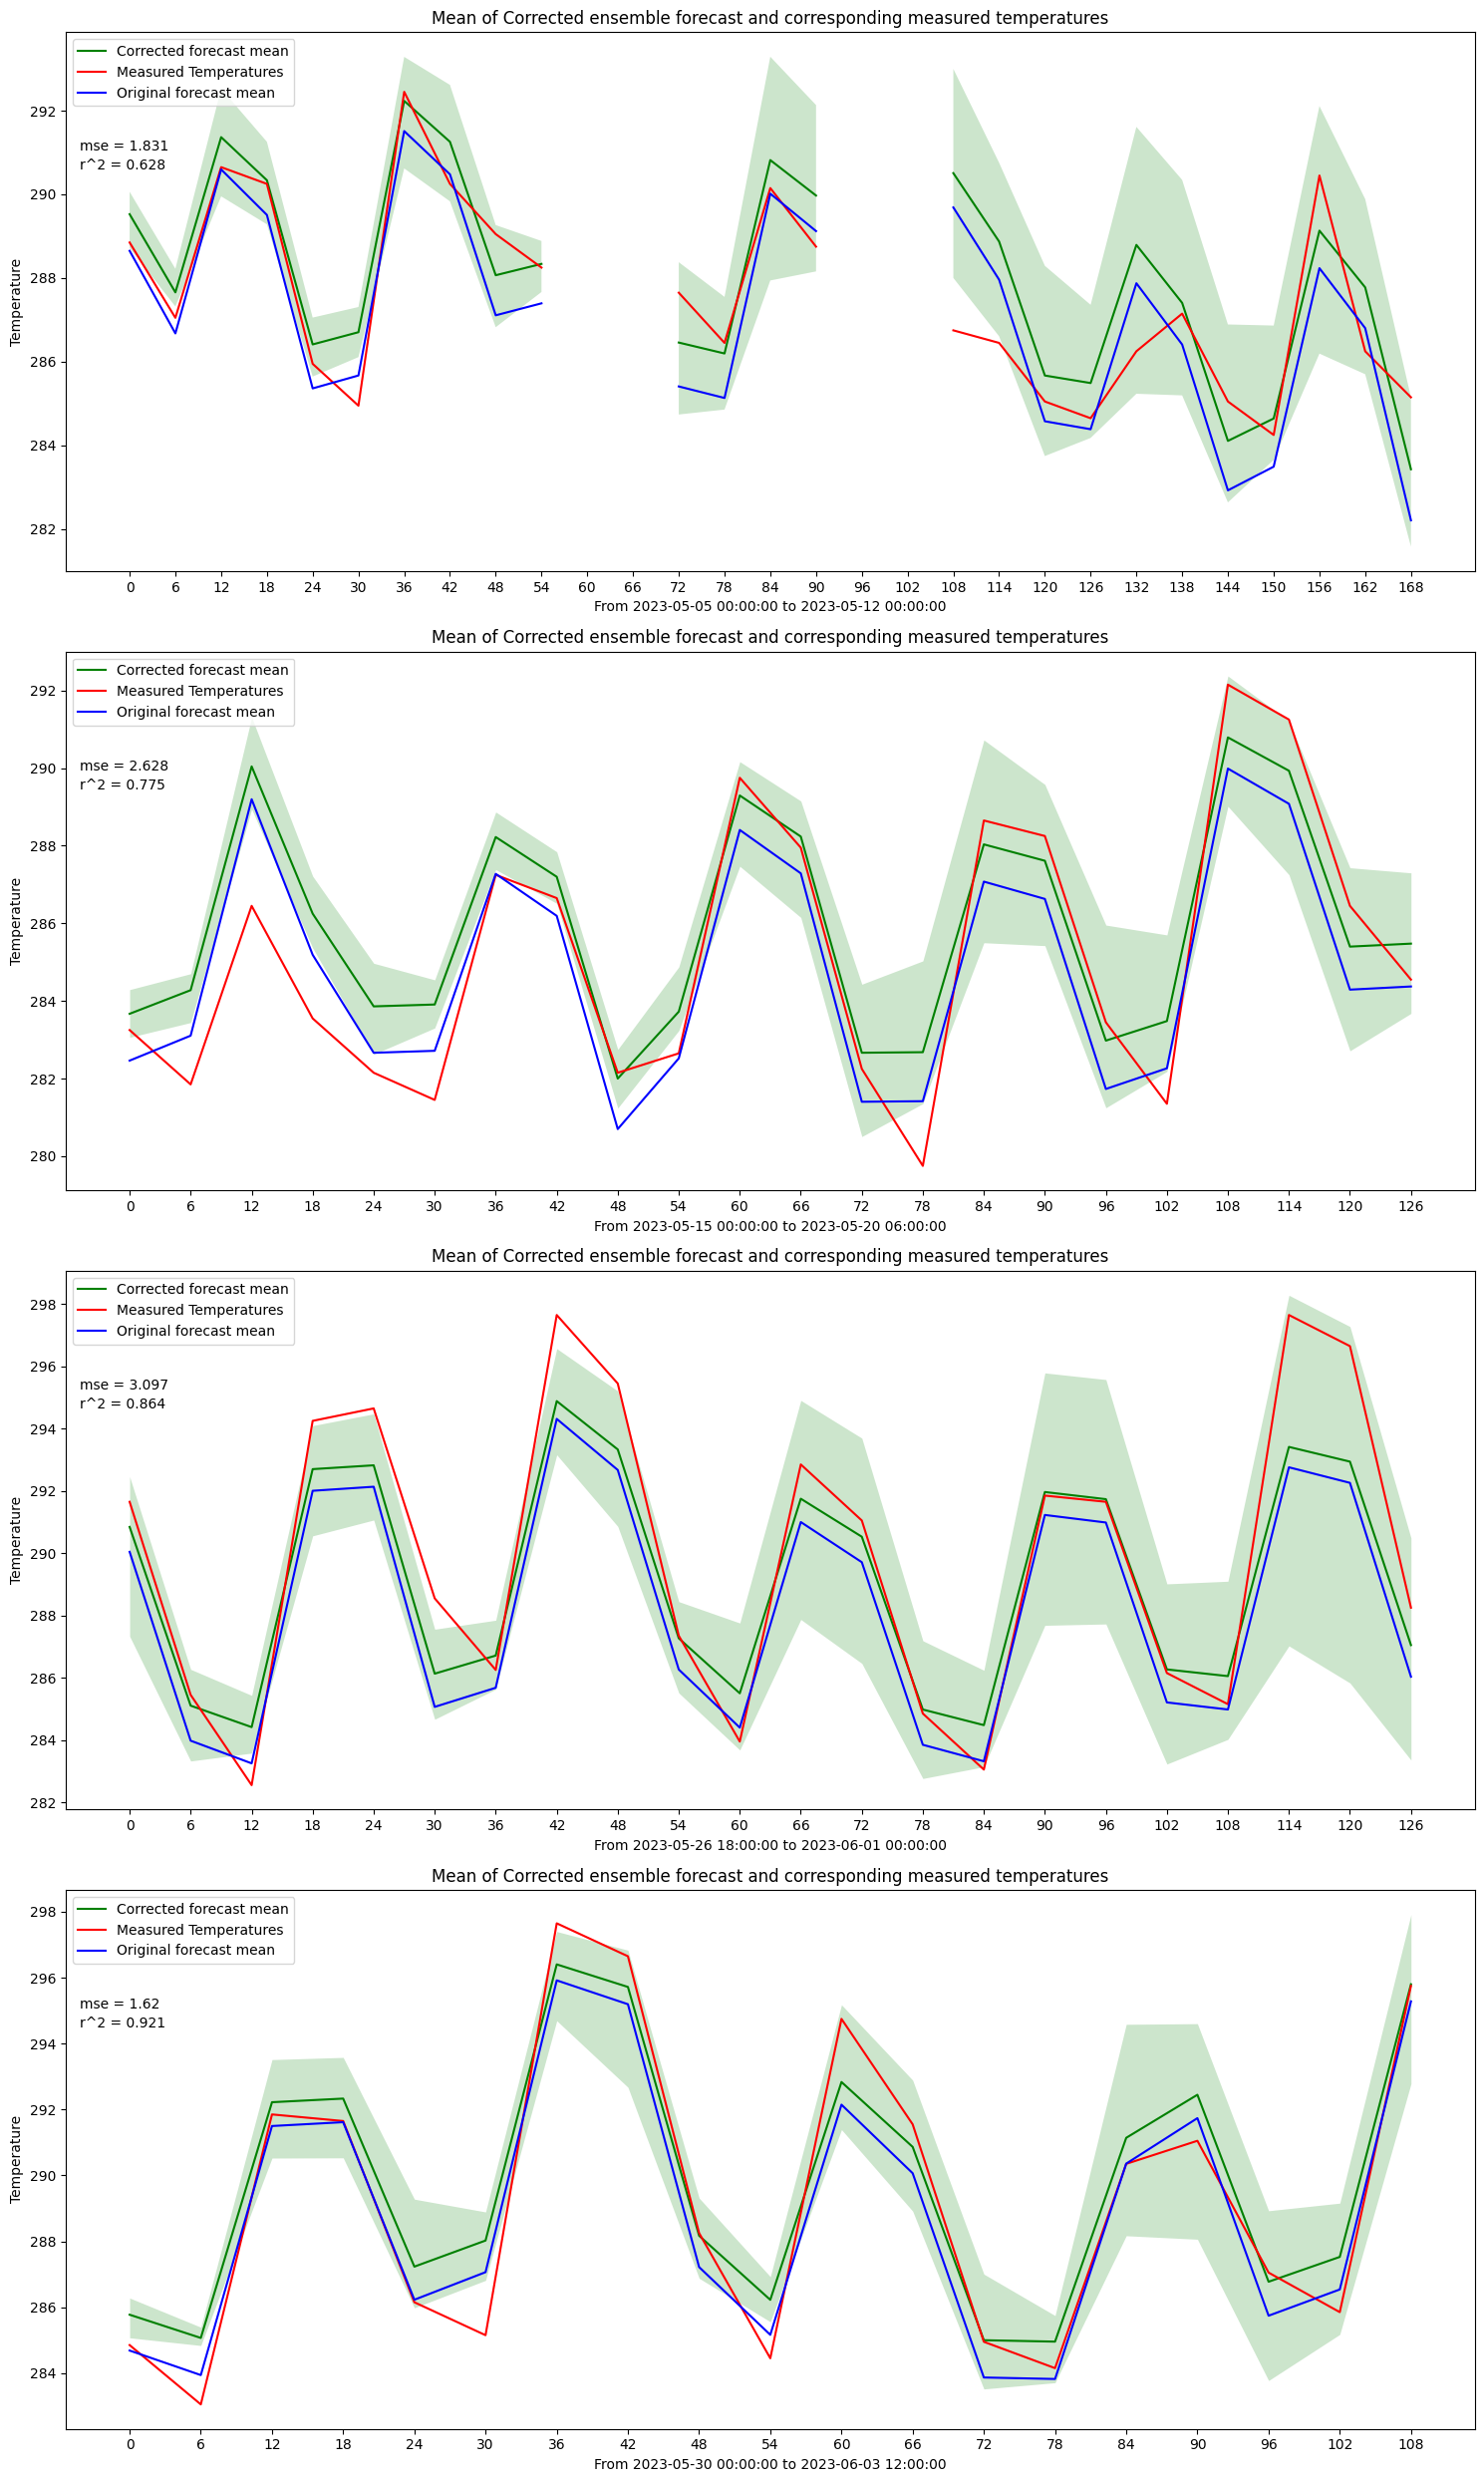

In [50]:
run_validation(val_set, linear_regression, transform_df_lr_fc, "Linear regression")

If certain graphs are split in multiple parts, this means that the measured temperature at the vlinder station was dropped out previously as it was not considered accurate enough

TODO: We should actually also compute the difference between the non corrected forecast and the measured temperatures.
-> Our prediction could also just do better on some dates when the underlying ensemble forecast did better
how do we measure that ? (just correlation ???)

TODO: Should display black zones at spots where forecast does NOT exist (-> we did cut certain values)

Basic Random forest
Mean mse: 2.1999550482815664
Variance mse: 0.19279633066724491
Mean r2_s: 0.7998208559153277


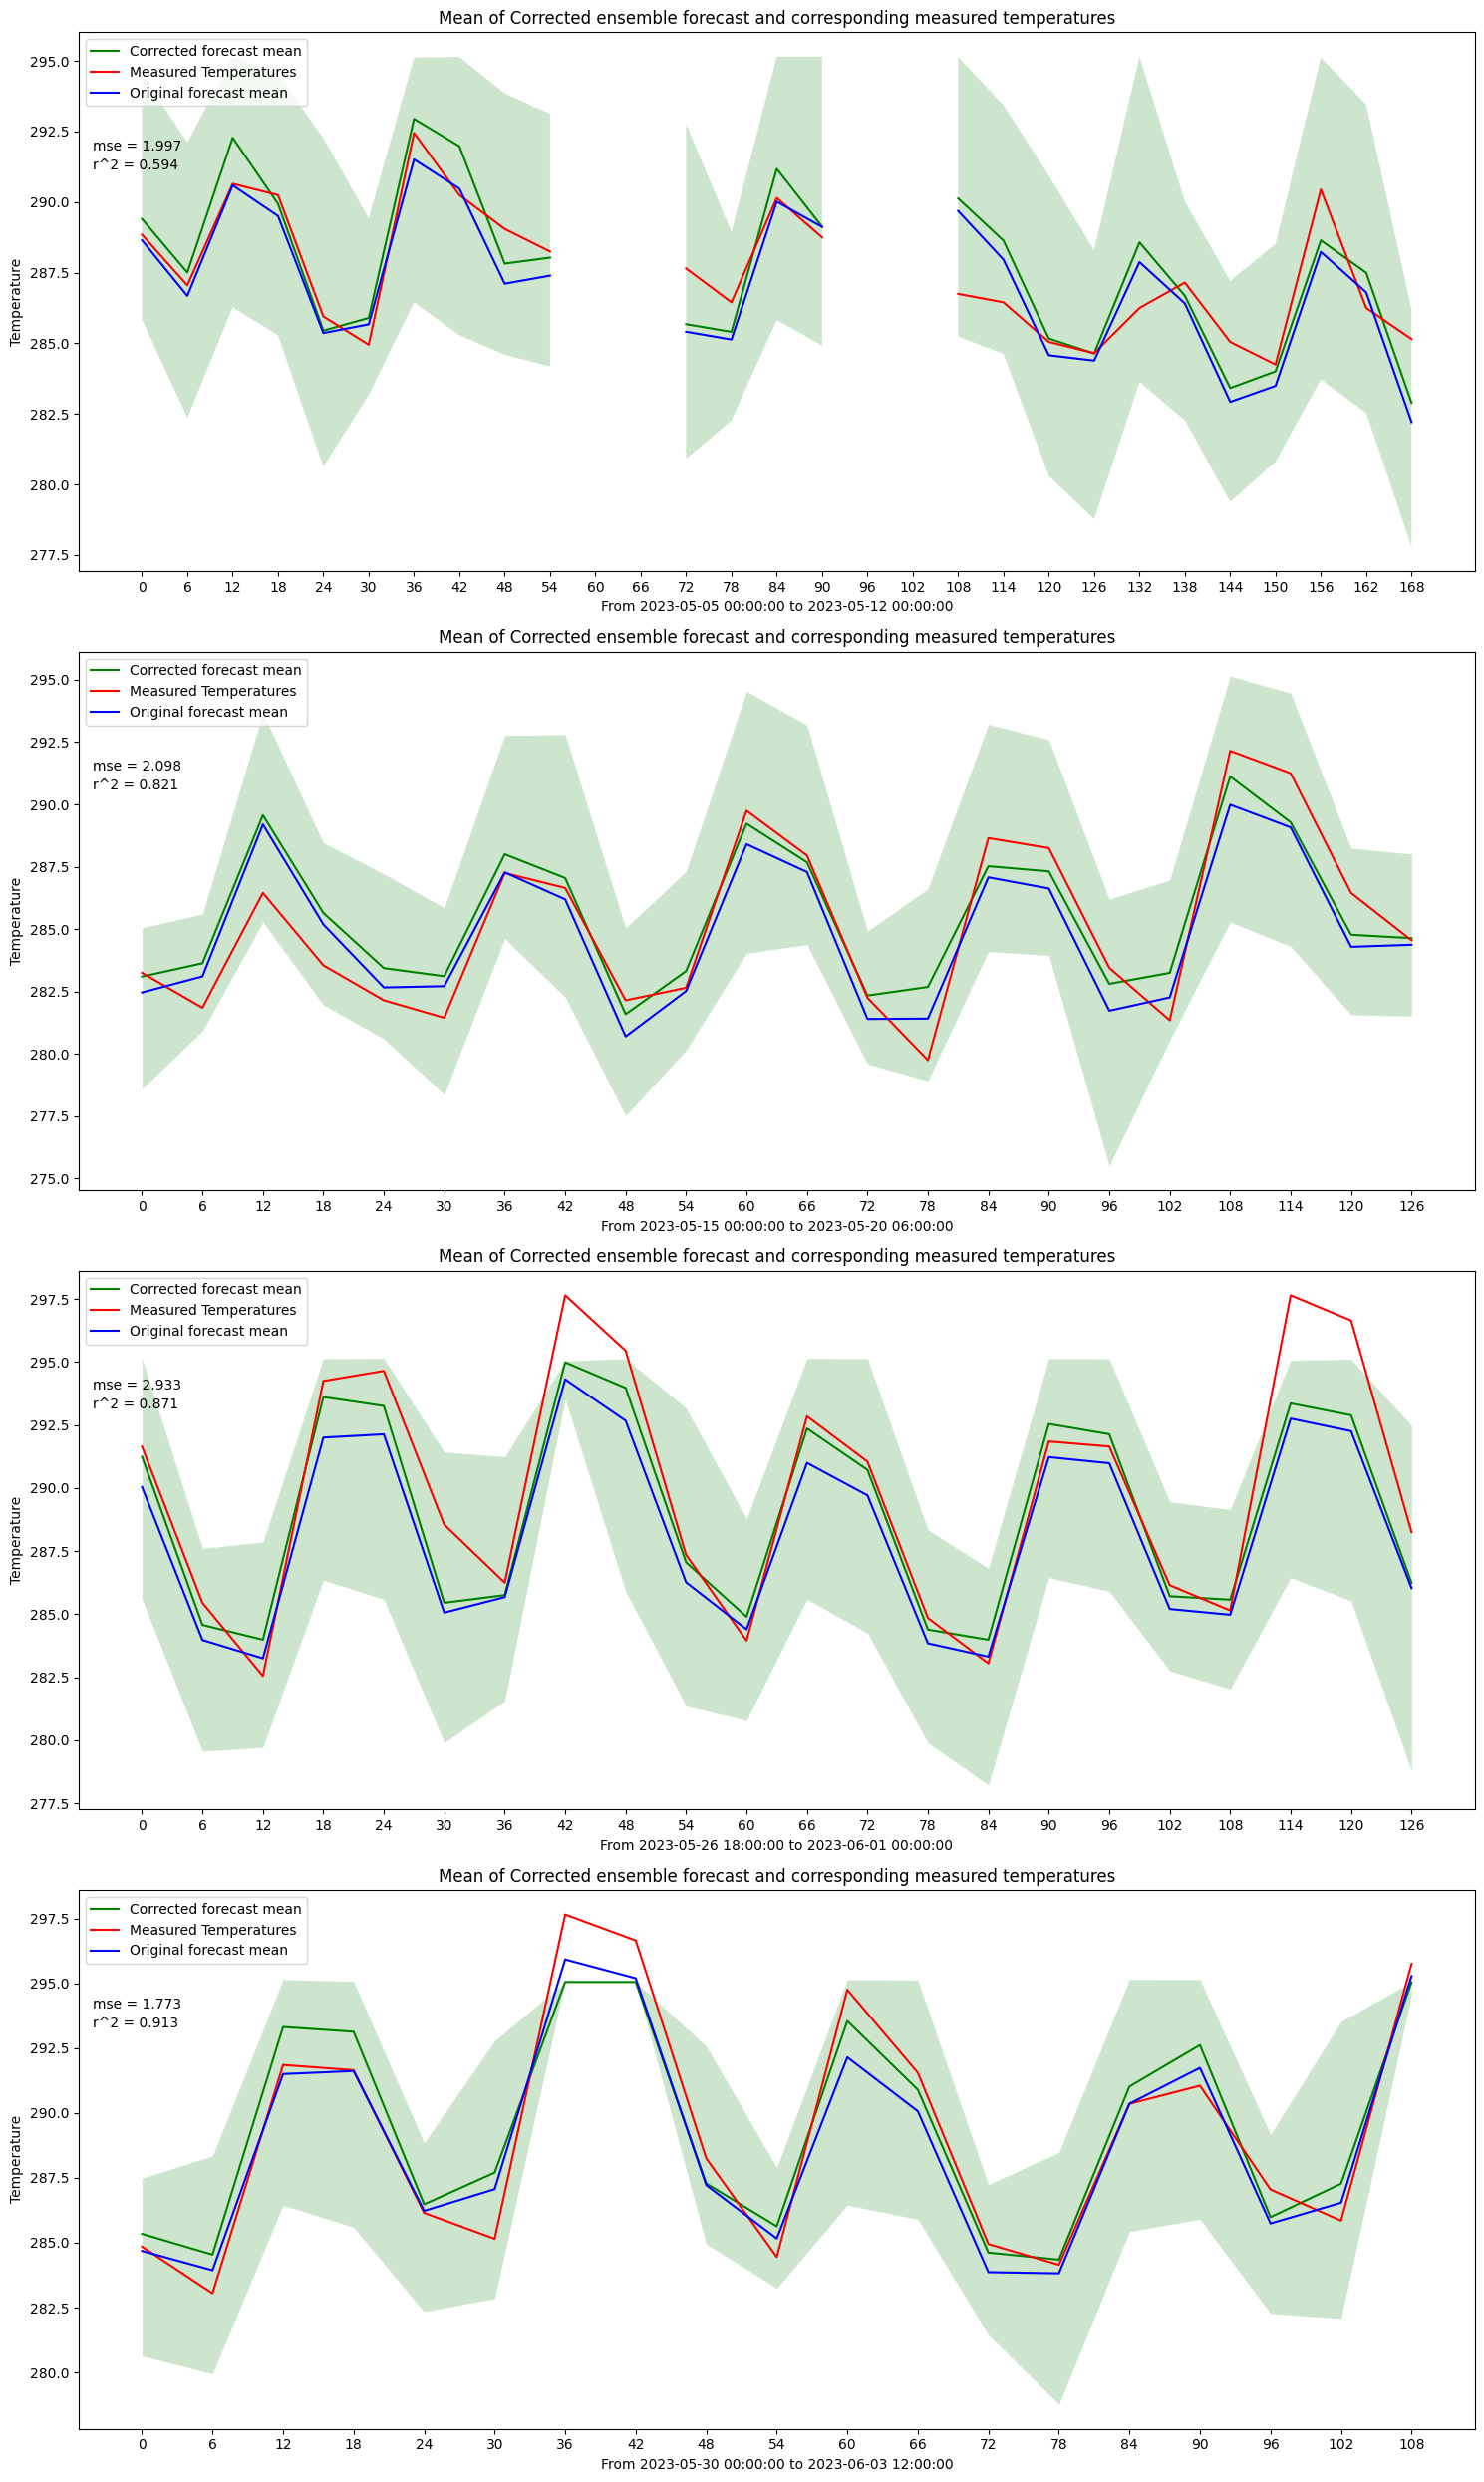

In [59]:
partial_transform_df_rf = partial(transform_df_rf_fc, rf_selected_features)
run_validation(val_set, rf_base, partial_transform_df_rf, "Basic Random forest")

K = 1, nb tree = 20 
Basic Random forest
Mean mse: 2.1999550482815664
Variance mse: 0.19279633066724491
Mean r2_s: 0.7998208559153277

K = 1
Basic Random forest
Mean mse: 3.0821393493813374
Variance mse: 1.2045567748505888
Mean r2_s: 0.7180229929964088

K = 1
Basic Random forest
Mean mse: 2.218202624801902
Variance mse: 0.20627756196376276
Mean r2_s: 0.7997129028938056

K = 5
Basic Random forest
Mean mse: 4.392683416634122
Variance mse: 0.9279463369557626
Mean r2_s: 0.5257879794396723

# Correcting forecast

In [ ]:
import re

def keep_digits(str):
    pattern = r'\D+' 
    return re.sub(pattern, '', str)

input_csv = "Forecast_23_03_2024.csv"
to_digits = keep_digits(input_csv)
output_csv_str = "Corr-" + to_digits[4:] + to_digits[2:4] + to_digits[:2] + "_TheBlaze.csv"
to_correct = pd.read_csv(f"weekly_forecast/{input_csv}")
prev_fc = to_correct[['time', 't2m', 'number']]

transformed = transform_df_lr_fc(to_correct)
transformed.reset_index(inplace=True)
transformed_datetime = transformed['time']
transformed.drop(columns='time', inplace=True)

df_corrected_t2m = transformed.copy()
for index, row in df_corrected_t2m.iterrows(): 
    y_row = linear_regression.predict(row.values.reshape(-1, 1))
    #squeeze to reshap np array into one dimension
    df_corrected_t2m.iloc[index] = np.squeeze(y_row)

df_corrected_t2m['time'] = transformed_datetime
df_corrected_t2m.set_index('time', inplace=True)

In [ ]:
# reshapes corrected temperatures values to have same format as to_correct
df_reshaped = df_corrected_t2m.T.melt(var_name='time', value_name='t2m')

to_correct['t2m'] = df_reshaped['t2m']

df_corrected = to_correct

df_corrected.to_csv(f"weekly_corrected/{output_csv_str}")

Displaying original and corrected forecasts

In [ ]:
def display_prev_corrected(df_fc, df_corr):
    """
        Displays forecast and corrected forecast through model
        df_fc and fc_corr should be fully features dataframes that at least have columns 'time', 't2m' and 'number'
    """
    prev_fc_mean = df_fc[['time', 't2m']].groupby('time').mean().reset_index()
    corrected_mean = df_corr[['time', 't2m']].groupby('time').mean().reset_index()
    
    hours =  np.arange(0, 6 * len(corrected_mean), 6)

    prev_fc_mean['t2m'] = prev_fc_mean['t2m'] - C_0
    corrected_mean['t2m'] = corrected_mean['t2m'] - C_0

    start = prev_fc_mean['time'].min()
    end = prev_fc_mean['time'].max()

    fig, ax = plt.subplots(figsize=(15, 8))

    # Get min and max values of previous forecast
    pvt_prev_fc = df_fc[['time', 't2m', 'number']].pivot(index='time', columns='number', values='t2m')
    y_fc_min = pvt_prev_fc.min(axis=1).values - C_0
    y_fc_max = pvt_prev_fc.max(axis=1).values - C_0
    ax.fill_between(hours, y_fc_min, y_fc_max, alpha=.2, linewidth=0)

    # get min and max value of corrected forecast
    pvt_corr_fc = df_corr[['time', 't2m', 'number']].pivot(index='time', columns='number', values='t2m')
    y_fc_min = pvt_corr_fc.min(axis=1).values - C_0
    y_fc_max = pvt_corr_fc.max(axis=1).values - C_0
    ax.fill_between(hours, y_fc_min, y_fc_max, alpha=.2, linewidth=0)

    plt.figure(figsize=(15, 8))
    ax.plot(hours, prev_fc_mean['t2m'], label='Original forecast')
    ax.plot(hours, corrected_mean['t2m'], label='Corrected forecast')
    ax.legend(loc='upper left')
    ax.set_xlabel(f"""From {start} to {end}""")
    ax.set_ylabel('Temperature')
    ax.set_title(f'Original and corrected forecast')
    ax.set_xticks(hours, [f"{h:02d}h" for h in hours], rotation=45)
    plt.show()

display_prev_corrected(prev_fc, df_corrected)